In [250]:
!pip install scipy

In [251]:
!pip install scikit-posthocs


  Using cached statsmodels-0.14.4-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (9.2 kB)
  Using cached patsy-1.0.1-py2.py3-none-any.whl.metadata (3.3 kB)
Using cached statsmodels-0.14.4-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (10.7 MB)
Using cached patsy-1.0.1-py2.py3-none-any.whl (232 kB)


# Importação de Pacotes e modulos

In [1]:
import mlflow

In [2]:
import pandas as pd
import numpy as np

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
import networkx as nx

In [232]:
from pathlib import Path
from sklearn.preprocessing import StandardScaler,RobustScaler, LabelEncoder,MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage

In [5]:
from sklearn.metrics import (
    silhouette_score,
    davies_bouldin_score,
    calinski_harabasz_score,
    adjusted_rand_score,
    v_measure_score,
    normalized_mutual_info_score,
    fowlkes_mallows_score
)

In [6]:
from loguru import logger

In [7]:
from sklearn.metrics import accuracy_score, classification_report

In [8]:
from sklearn.neighbors import kneighbors_graph

In [9]:
PROJ_ROOT = Path('__file__').resolve().parents[1]
logger.info(f"PROJ_ROOT path is: {PROJ_ROOT}")

2025-06-11 11:51:59.748 | INFO     | __main__:<module>:2 - PROJ_ROOT path is: /home/alessandro/Documentos/academico/mestrado/2025/aprendizado-maquina/trabalho-002/clustering_uff_ml


In [11]:
# Define logs directory
LOGS_DIR = PROJ_ROOT/"logs"
LOGS_DIR.mkdir(exist_ok=True)  

print("caminhodo projeto ->  ",LOGS_DIR)


caminhodo projeto ->   /home/alessandro/Documentos/academico/mestrado/2025/aprendizado-maquina/trabalho-002/clustering_uff_ml/logs


In [12]:
# Configure loguru to save logs to a file
logger.remove()  # Remove default console handler
logger.add(
    LOGS_DIR / "clustering.log",
    rotation="10 MB",  # Rotate log file when it reaches 10 MB
    retention="10 days",  # Keep logs for 10 days
    level="INFO",
    format="{time:YYYY-MM-DD HH:mm:ss} | {level} | {message}"
)


1

# KDD 1 Seleção


In [13]:
path = '../data/raw/iris/iris.data'

## Identificação de Dados

In [14]:
def carregaDataset(path,nameColumns="") -> pd.DataFrame:
    try:
        if name_columns!="":
            return pd.read_csv(path,header=None,names=name_columns)
        return pd.read_csv(path)
    except Exception as e:
        logger.error(f"Problema ao carregar o dataset - {path}")

In [15]:
name_columns = ['sepal_lenght','sepal_width','petal_lenght','petal_width','target']

In [16]:
ds = carregaDataset(path,name_columns)

In [17]:
ds.head()

,sepal_lenght,sepal_width,petal_lenght,petal_width,target
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [18]:
ds.describe()

,sepal_lenght,sepal_width,petal_lenght,petal_width
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.054000,3.758667,1.198667
std,0.828066,0.433594,1.764420,0.763161
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


## Caracterização dos dados

In [19]:
ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sepal_lenght  150 non-null    float64
 1   sepal_width   150 non-null    float64
 2   petal_lenght  150 non-null    float64
 3   petal_width   150 non-null    float64
 4   target        150 non-null    object 
dtypes: float64(4), object(1)
memory usage: 6.0+ KB


## Definição do subconjunto 

Será utilizado todo o dataset pois este dataset já está pronto balanceado e não possui dados ausentes

In [20]:
X = ds.drop('target', axis=1)
y_true = ds['target']

# KDD 2 Pré-processamento
Como os algoritmos de clustering são baseados em distância, precisamos garantir que todas as features estejam na mesma escala.

In [21]:
def scaleData(X,metodo='standard'):
    try:
        if metodo == 'standard':
            scaler = StandardScaler()
        elif metodo == "robust":
            scaler =RobustScaler()
        else: 
            raise ValueError("Método inválido: use 'standard ou robust'")
            
        logger.success(f"realizada scalonamento do dataset com {metodo}")
        return scaler.fit_transform(X)
        
    except Exception as e:
        logger.error(f'{e} | LOCAL: função scaleData()')
           

In [114]:
def plot_pairplot(ds,titulo=None):
    sns.set_theme(style="ticks")
    
    # hue='target': diz ao seaborn para colorir os pontos com base na coluna 'target' que contém as especies
    # diag_kind='kde': mostra uma estimativa de densidade na diagonal em vez de um histograma
    # markers: usa marcadores diferentes para cada espécie, melhorando a acessibilidade
    sns.pairplot(
        ds, 
        hue='target', 
        diag_kind='kde',
        markers=["o", "s", "D"],
        palette='viridis' # esquema de cores 
    )
    

    plt.suptitle(f"{titulo}", y=1.02, fontsize=16)    
    plt.show()


## Análise Visual discrimiante do dataset sem pré-processamento

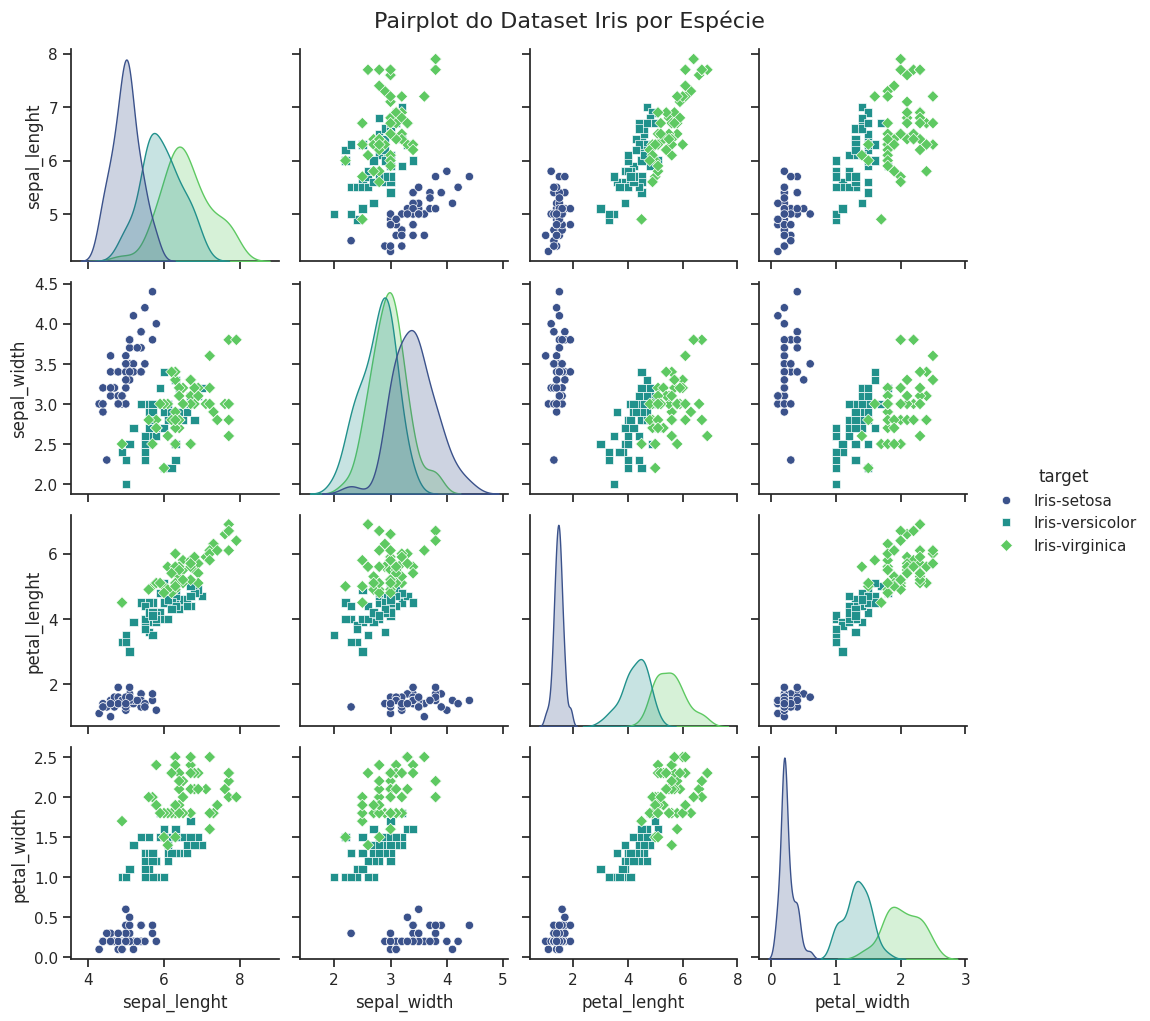

In [116]:
plot_pairplot(ds,"Pairplot do Dataset Iris por Espécie")

## Limpeza de Dados 

Dados estão balanceados igualmente entre as 3 classes

### Remoção de ruidos

#### Análise de Boxplot

In [22]:
X_scaled = scaleData(X,metodo='standard')

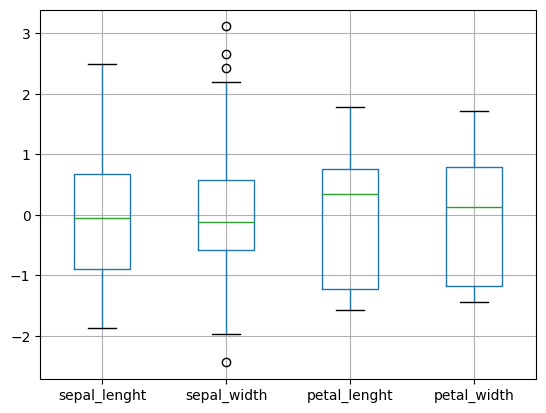

In [104]:
pd.DataFrame(X_scaled,columns=name_columns[:-1] ).boxplot()
plt.show()

In [95]:
X_robust = scaleData(X, metodo='robust')

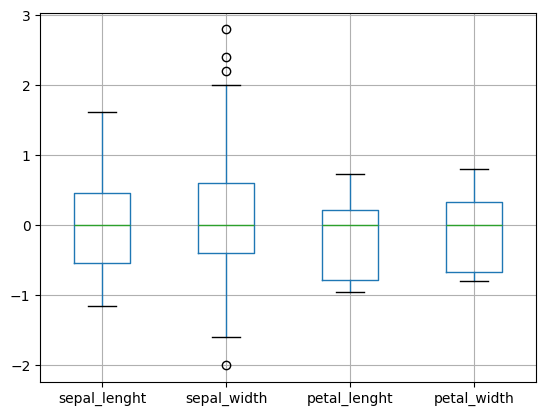

In [106]:
pd.DataFrame(X_robust,columns=name_columns[:-1]).boxplot()
plt.show()

A análise de boxplot evidência que a única variável que possui outlier é sepal_width ( vale ressaltare que ruido e outilier são diferentes como de3scrito na seção Ruido Vs Outlier do artigo
https://www.sciencedirect.com/science/article/abs/pii/S1574013720304068 

### Tratamento de valores Ausentes

Sem valores faltamtes ou nulos

In [27]:
ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sepal_lenght  150 non-null    float64
 1   sepal_width   150 non-null    float64
 2   petal_lenght  150 non-null    float64
 3   petal_width   150 non-null    float64
 4   target        150 non-null    object 
dtypes: float64(4), object(1)
memory usage: 6.0+ KB


### Deduplicação

In [28]:
ds[ds.duplicated(keep=False)]

,sepal_lenght,sepal_width,petal_lenght,petal_width,target
9,4.9,3.1,1.5,0.1,Iris-setosa
34,4.9,3.1,1.5,0.1,Iris-setosa
37,4.9,3.1,1.5,0.1,Iris-setosa
101,5.8,2.7,5.1,1.9,Iris-virginica
142,5.8,2.7,5.1,1.9,Iris-virginica


Os registros 9,34,37,101,142 estão repetidos

In [32]:
ds_deduplicado = ds.drop_duplicates(keep='first', inplace=False)

In [33]:
ds_deduplicado 

,sepal_lenght,sepal_width,petal_lenght,petal_width,target
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,Iris-virginica
146,6.3,2.5,5.0,1.9,Iris-virginica
147,6.5,3.0,5.2,2.0,Iris-virginica
148,6.2,3.4,5.4,2.3,Iris-virginica


In [99]:
ds.to_csv('../data/interim/001-apcb-deduplicado.csv')

### Tratamento da variável Target categórica

## Normalização/Escalonamento

In [35]:
lb =LabelEncoder()
lb.fit_transform(ds_deduplicado.target)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [37]:
y_true_lb = lb.fit_transform(ds_deduplicado.target)

In [38]:
ds_deduplicado_lb = ds_deduplicado.copy()
ds_deduplicado_lb['target'] =  y_true_lb

In [39]:
ds_deduplicado_lb.to_csv('../data/interim/001-apcb-deduplicado_lb.csv')

# KDD 3 Transformação

## Redução de dimensionalidade 

## Engenharia de Features

## Análise Exploratória

In [40]:
def reducaoDimensao(X, n_componentes=3, feature_names=None):
    """
    Realiza a redução de dimensionalidade utilizando PCA.

    Args:
        X (np.array ou pd.DataFrame): O conjunto de dados de entrada (espera-se que já esteja padronizado se você o chama com X_scaled).
                                     Se X for um pandas DataFrame, seu índice será usado; caso contrário, um índice padrão será criado.
        n_componentes (int): O número de componentes principais a serem mantidos.
        feature_names (list, optional): Uma lista de strings com os nomes das features originais.
                                        Essencial para rotular corretamente os loadings.
                                        Se None e X for um DataFrame, X.columns será usado.
                                        Se None e X for um array NumPy, serão gerados nomes genéricos (feature_1, feature_2...).

    Returns:
        tuple:
            - pd.DataFrame: O dataset transformado com a dimensionalidade reduzida.
            - pd.DataFrame: DataFrame com a variância explicada por cada componente e acumulada,
                            e a relevância (loadings) de cada feature para cada componente.
                            As linhas representam os componentes e as colunas representam as features.
    """
    try:
        X_processed = X

        # Determinar os nomes das features se não forem fornecidos explicitamente
        if feature_names is None:
            if isinstance(X, pd.DataFrame):
                feature_names = X.columns.tolist()
            else: # X é um array NumPy
                feature_names = [f'feature_{i+1}' for i in range(X.shape[1])]


        pca = PCA(n_components=n_componentes)
        X_pca_array = pca.fit_transform(X_processed)

        # Cria o DataFrame X_pca
        colunas_pca = [f'Componente_{i+1}' for i in range(X_pca_array.shape[1])]
        if hasattr(X, 'index') and isinstance(X, pd.DataFrame):
            X_pca = pd.DataFrame(X_pca_array, columns=colunas_pca, index=X.index)
        else:
            X_pca = pd.DataFrame(X_pca_array, columns=colunas_pca)


 
        # Cria um DataFrame para os loadings
        # pca.components_ tem o formato (n_components, n_features)
        # As colunas serão os nomes das features, e o índice serão os nomes dos componentes (PC1, PC2, etc.)
        loadings_df = pd.DataFrame(pca.components_,
                                   columns=feature_names,
                                   index=[f'PC{i+1}' for i in range(len(pca.explained_variance_ratio_))])

        # Criar o DataFrame de variância explicada e acumulada
        df_variance_data = {
            'Variancia_Explicada': pca.explained_variance_ratio_,
            'Variancia_Acumulada': pca.explained_variance_ratio_.cumsum()
        }
        # O índice deste DataFrame também serão os nomes dos componentes para facilitar a concatenação
        df_variance = pd.DataFrame(df_variance_data,
                                   index=[f'PC{i+1}' for i in range(len(pca.explained_variance_ratio_))])

        # Concatenar os DataFrames de variância e loadings horizontalmente (pelas colunas)
        # O resultado será df_pca_var com colunas de variância e colunas de loadings para cada feature
        df_pca_var = pd.concat([df_variance, loadings_df], axis=1)


        logger.success("Redução de dimensionalidade realizada!")
        return X_pca, df_pca_var
    except Exception as e:
        logger.error(f"Problema na redução de dimensionalidade: {e}")
        return None, None # Retorna None para ambos em caso de erro

In [41]:
def cluster(X, metodo, numero_cluster=3):
    if metodo == 'kmeans':
        modelo = KMeans(n_clusters=numero_cluster,random_state=42)

    elif metodo =='hcluster':
        modelo = AgglomerativeClustering(n_clusters=numero_cluster)
    
    else: raise ValueError("Método inválido: use 'kmeans ou hcluster'")
    labels = modelo.fit_transform(X)
    return labels, modelo

In [42]:
def plot_scatter(X,Y,hue=None,xlabel='',ylabel='',titulo='',legenda='',paletaCores=None,tamanhoPonto=100,transparencia=0.5):
    sns.scatterplot(
        x=X, 
        y=Y, 
        hue=hue,  # A 'mágica' acontece aqui: colorir pela variável de grupo
        palette=paletaCores, # Fornecendo as cores exatas que você quer
        s=tamanhoPonto,              # Tamanho dos pontos
        alpha=transparencia,          # Transparência
        legend='full'if legenda!='' else None
    )
    
    plt.title('Clusters Visualizados com PCA com coloração por Target')
    plt.xlabel('Primeiro Componente Principal')
    plt.ylabel('Segundo Componente Principal')
    plt.legend(title='Cluster ID')
    plt.show()

### Usando PCA na EDA para avaliar o quão bem o dataset é agrupado por dois componentes 

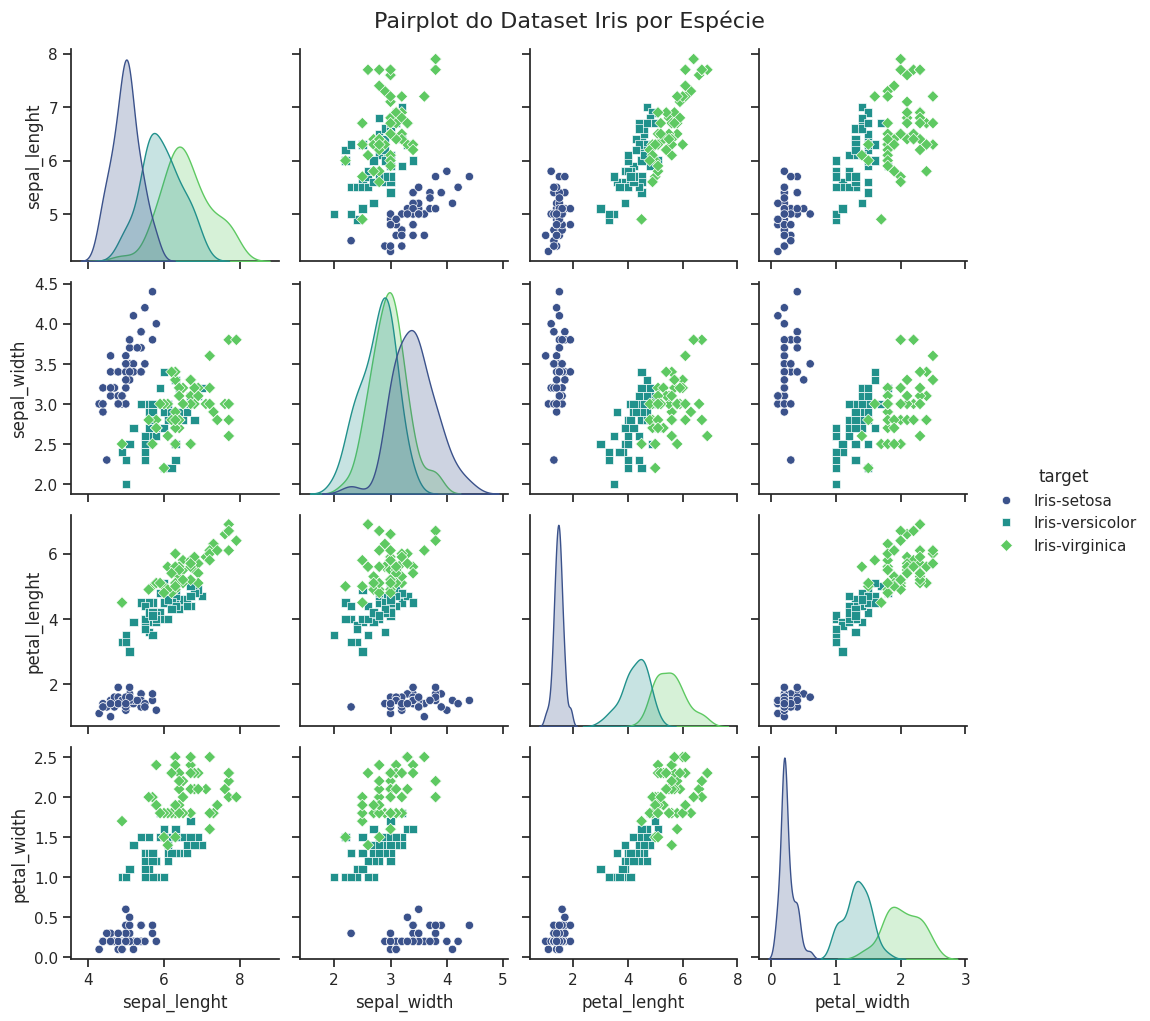

In [115]:
plot_pairplot(ds,"Pairplot do Dataset Iris por Espécie")

In [55]:
list(ds.columns)

['sepal_lenght', 'sepal_width', 'petal_lenght', 'petal_width', 'target']

In [82]:
X_pca,df_pca_var = reducaoDimensao(X=X_scaled, n_componentes=3) 

In [83]:
X_pca

,Componente_1,Componente_2,Componente_3
0,-2.264542,0.505704,0.121943
1,-2.086426,-0.655405,0.227251
2,-2.367950,-0.318477,-0.051480
3,-2.304197,-0.575368,-0.098860
4,-2.388777,0.674767,-0.021428
...,...,...,...
145,1.870522,0.382822,-0.254532
146,1.558492,-0.905314,0.025382
147,1.520845,0.266795,-0.179277
148,1.376391,1.016362,-0.931405


In [84]:
X_pca.head()

,Componente_1,Componente_2,Componente_3
0,-2.264542,0.505704,0.121943
1,-2.086426,-0.655405,0.227251
2,-2.367950,-0.318477,-0.051480
3,-2.304197,-0.575368,-0.098860
4,-2.388777,0.674767,-0.021428


In [85]:
df_pca_var.head()

,Variancia_Explicada,Variancia_Acumulada,feature_1,feature_2,feature_3,feature_4
PC1,0.727705,0.727705,0.522372,-0.263355,0.581254,0.565611
PC2,0.230305,0.958010,0.372318,0.925556,0.021095,0.065416
PC3,0.036838,0.994848,0.721017,-0.242033,-0.140892,-0.633801


In [86]:
list(zip(list(ds.columns)[:-1], list(df_pca_var.columns)[2:]))


[('sepal_lenght', 'feature_1'),
 ('sepal_width', 'feature_2'),
 ('petal_lenght', 'feature_3'),
 ('petal_width', 'feature_4')]

In [87]:
df_pca_var

,Variancia_Explicada,Variancia_Acumulada,feature_1,feature_2,feature_3,feature_4
PC1,0.727705,0.727705,0.522372,-0.263355,0.581254,0.565611
PC2,0.230305,0.958010,0.372318,0.925556,0.021095,0.065416
PC3,0.036838,0.994848,0.721017,-0.242033,-0.140892,-0.633801


In [107]:
X_pca_robust,df_pca_var_robust = reducaoDimensao(X=X_robust,n_componentes=3)

In [108]:
df_pca_var_robust

,Variancia_Explicada,Variancia_Acumulada,feature_1,feature_2,feature_3,feature_4
PC1,0.615788,0.615788,-0.447657,0.641472,-0.450984,-0.429802
PC2,0.351235,0.967022,0.548645,0.746909,0.254204,0.276580
PC3,0.029714,0.996736,0.676170,-0.159989,-0.259558,-0.670691


/tmp/ipykernel_20934/808467657.py:15: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Cluster ID')


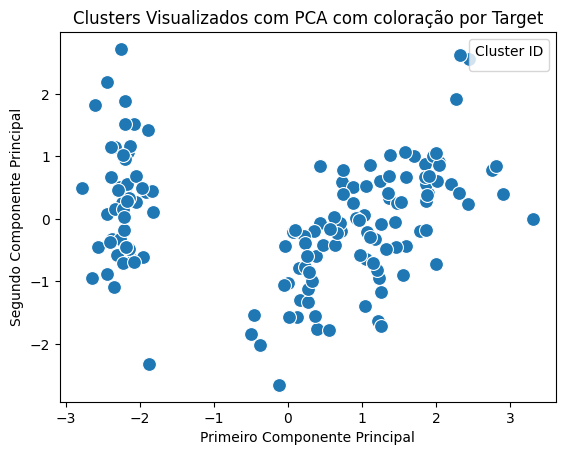

In [109]:
plot_scatter(X=X_pca['Componente_1'],
             Y=X_pca['Componente_2'],
             titulo='Clusters Visualizados com PCA sem coloração por Target com escalonamento Padronização',
             xlabel='Primeiro Componente Principal',
             ylabel='Segundo Componente Principal',
             transparencia=1
            )

/tmp/ipykernel_20934/808467657.py:15: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Cluster ID')


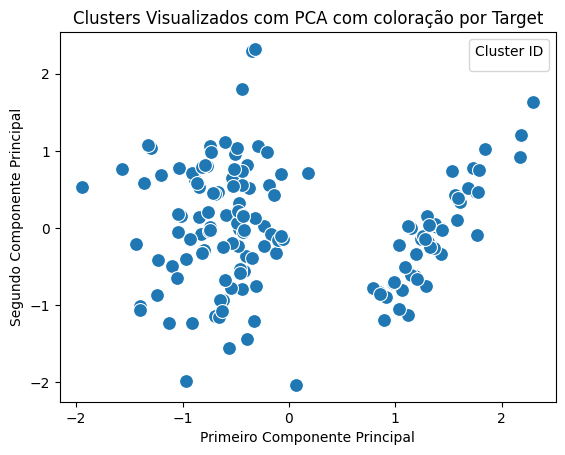

In [110]:
plot_scatter(X=X_pca_robust['Componente_1'],
             Y=X_pca_robust['Componente_2'],
             titulo='Clusters Visualizados com PCA sem coloração por Target com escalonamento RobustScaler',
             xlabel='Primeiro Componente Principal',
             ylabel='Segundo Componente Principal',
             transparencia=1
            )

/tmp/ipykernel_20934/808467657.py:15: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Cluster ID')


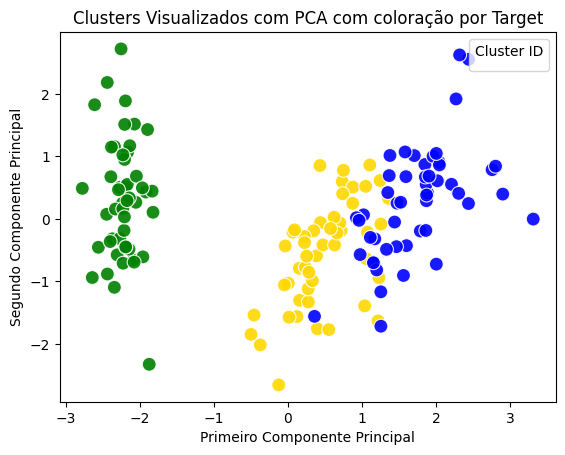

In [111]:
plot_scatter(X=X_pca['Componente_1'],
             Y=X_pca['Componente_2'],
             hue=y_true, 
             paletaCores=['green', 'gold', 'blue'],
             tamanhoPonto=100, 
             transparencia=0.9, 
             titulo='Clusters Visualizados com PCA com coloração por Target com escaloamento por Padronização (StandardScaler)',
             xlabel='Primeiro Componente Principal',
             ylabel='Segundo Componente Principal',
             
            )

/tmp/ipykernel_20934/808467657.py:15: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Cluster ID')


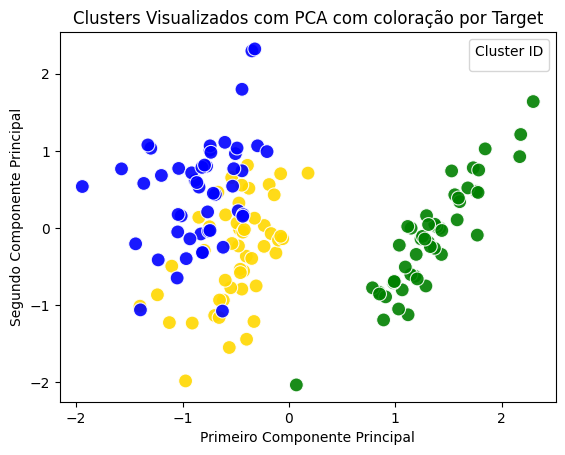

In [113]:
plot_scatter(X=X_pca_robust['Componente_1'],
             Y=X_pca_robust['Componente_2'],
             hue=y_true, 
             paletaCores=['green', 'gold', 'blue'],
             tamanhoPonto=100, 
             transparencia=0.9, 
             titulo='Clusters Visualizados com PCA com coloração por Target com escaloamento por RobustScaler ',
             xlabel='Primeiro Componente Principal',
             ylabel='Segundo Componente Principal',
             
            )

### PAIRPLOT

# KDD 4 Mineração  de Dados

## Escolha de modelo(s) 

In [121]:
def run_single_cluster(X_scaled, k, algorithm='kmeans', linkage='ward'):
    """
    Executa um algoritmo de clustering uma vez para um k específico.

    Args:
        X_scaled (np.ndarray): Dados padronizados.
        k (int): O número de clusters para formar.
        algorithm (str): 'kmeans' ou 'hcluster'.
        linkage (str): Método de linkage para hcluster.

    Returns:
        tuple: Uma tupla contendo (labels, inertia, model).
               'inertia' será np.nan para hcluster.
    """
    if algorithm == 'kmeans':
        model = KMeans(n_clusters=k, random_state=42, n_init='auto')
        labels = model.fit_predict(X_scaled)
        inertia = model.inertia_
    elif algorithm == 'hcluster':
        model = AgglomerativeClustering(n_clusters=k, metric='euclidean', linkage=linkage)
        labels = model.fit_predict(X_scaled)
        inertia = np.nan  # hcluster não tem o atributo 'inertia'
    else:
        raise ValueError("Algoritmo não suportado. Escolha 'kmeans' ou 'hcluster'.")

    return labels, inertia, model

In [122]:
def evaluate_multiple_clusters(X_scaled, y_true, cluster_range, algorithm='kmeans', linkage='ward'):
    """
    Testa um algoritmo de clustering para um intervalo de 'k' e retorna as métricas de avaliação.

    Args:
        X_scaled (np.ndarray): Dados padronizados.
        y_true (pd.Series or np.ndarray): Rótulos verdadeiros.
        cluster_range (range or list): O intervalo de k's a testar (ex: range(2, 11)).
        algorithm (str): 'kmeans' ou 'hcluster'.
        linkage (str): Método de linkage para hcluster.

    Returns:
        pd.DataFrame: Um DataFrame com todas as métricas para cada valor de k.
    """
    metrics_list = []
    for k in cluster_range:
        # Usa a função "motor" para obter os resultados para este 'k'
        labels, inertia, _ = run_single_cluster(X_scaled, k, algorithm, linkage)

        # Calcula todas as métricas
        metrics = {
            'inertia': inertia,
            'silhouette': silhouette_score(X_scaled, labels),
            'davies_bouldin': davies_bouldin_score(X_scaled, labels),
            'calinski_harabasz': calinski_harabasz_score(X_scaled, labels),
            'ari': adjusted_rand_score(y_true, labels),
            'v_measure': v_measure_score(y_true, labels),
            'nmi': normalized_mutual_info_score(y_true, labels),
            'fowlkes_mallows': fowlkes_mallows_score(y_true, labels)
        }
        metrics_list.append(metrics)

    # O return está FORA do loop, retornando o resultado completo
    results_df = pd.DataFrame(metrics_list, index=cluster_range)
    results_df.index.name = 'k'
    return results_df

In [156]:
def plot_clustering_evaluation(results_df,titulo=None):
    """
    Plota as principais métricas de avaliação de clustering a partir de um DataFrame de resultados.

    Args:
        results_df (pd.DataFrame): DataFrame com 'k' como índice e métricas nas colunas.
    """
    # Cria uma figura com 4 subplots (2 linhas, 2 colunas)
    fig, axes = plt.subplots(2, 2, figsize=(18, 12))
    fig.suptitle(f'Análise de Critérios de Avaliação de Cluster - {titulo}', fontsize=18, y=1.02)
    
    k_values = results_df.index
    
    # --- 1. Critério Relativo: Método do Cotovelo (Inertia) ---
    ax1 = axes[0, 0]
    ax1.plot(k_values, results_df['inertia'], marker='o', linestyle='--')
    ax1.set_title(f'Método do Cotovelo (Critério Relativo) para {titulo}', fontsize=14)
    ax1.set_xlabel('Número de Clusters (k)')
    ax1.set_ylabel('Inertia (WCSS) - Menor é Melhor')
    ax1.grid(True)

    # --- 2. Critério Interno: Silhouette Score ---
    ax2 = axes[0, 1]
    ax2.plot(k_values, results_df['silhouette'], marker='o', linestyle='--', color='g')
    ax2.set_title(f'Silhouette Score (Critério Interno) - {titulo}', fontsize=14)
    ax2.set_xlabel('Número de Clusters (k)')
    ax2.set_ylabel('Silhouette Score - Maior é Melhor')
    ax2.grid(True)
    
    # --- 3. Outros Critérios Internos (ex: Davies-Bouldin) ---
    ax3 = axes[1, 0]
    ax3.plot(k_values, results_df['davies_bouldin'], marker='o', linestyle='--', color='r')
    ax3.set_title(f'Davies-Bouldin Score (Critério Interno) - {titulo}', fontsize=14)
    ax3.set_xlabel('Número de Clusters (k)')
    ax3.set_ylabel('Davies-Bouldin - Menor é Melhor')
    ax3.grid(True)
    
    # --- 4. Critério Externo: Adjusted Rand Index (ARI) ---
    ax4 = axes[1, 1]
    ax4.plot(k_values, results_df['ari'], marker='o', linestyle='--', color='purple')
    ax4.set_title(f'Adjusted Rand Index (Critério Externo) - {titulo}', fontsize=14)
    ax4.set_xlabel('Número de Clusters (k)')
    ax4.set_ylabel('ARI - Maior é Melhor')
    ax4.grid(True)
    
    # Ajusta o layout para evitar sobreposição de títulos
    plt.tight_layout(rect=[0, 0.03, 1, 0.98])
    plt.show()


### Kmeans

## Aplicação de modelos

## Clustering com escaolmaneto por padronização 

In [ ]:
# Definindo  o intervalo de k a ser testado
k_range_to_test = range(2, 11)

In [127]:
n_cluster = 3

### Com kmeans + StandardScaler

In [215]:
# Treinando o modelo final com o k escolhido para kmeans
final_k = n_cluster
final_labels, final_inertia, final_model = run_single_cluster(X_scaled, final_k, algorithm='kmeans')

print(f"\nModelo K-Means final treinado com k={final_k}")


Modelo K-Means final treinado com k=3


In [217]:
# Obtensdo a tabela de métricas para o K-Means
kmeans_evaluation = evaluate_multiple_clusters(X_scaled, y_true, k_range_to_test, algorithm='kmeans')


In [218]:
print("--- Tabela de Avaliação K-Means ---")
display(kmeans_evaluation)

--- Tabela de Avaliação K-Means ---


,inertia,silhouette,davies_bouldin,calinski_harabasz,ari,v_measure,nmi,fowlkes_mallows
k,,,,,,,,
2,223.732006,0.580184,0.597555,248.903428,0.568116,0.733680,0.733680,0.771454
3,192.037174,0.478724,0.786801,156.143038,0.428951,0.587378,0.587378,0.661310
4,114.682216,0.387247,0.865605,205.949969,0.493292,0.609087,0.609087,0.647329
5,91.295445,0.347265,0.940632,201.987516,0.437172,0.590811,0.590811,0.596313
6,81.760261,0.336223,0.990627,182.549618,0.478868,0.633982,0.633982,0.628443
7,80.982381,0.268562,1.121924,152.748286,0.388810,0.567147,0.567147,0.554604
8,68.086239,0.315682,1.080345,158.479169,0.380247,0.535420,0.535420,0.548786
9,59.385289,0.299142,1.068418,160.449405,0.295319,0.524827,0.524827,0.474939
10,52.989997,0.321103,1.015119,160.578315,0.311790,0.545280,0.545280,0.493397


### Com HCluster + StandardScaler

In [126]:
# Obteção da tabela de métricas para o H-Cluster
hcluster_evaluation = evaluate_multiple_clusters(X_scaled, y_true, k_range_to_test, algorithm='hcluster')

print("\n--- Tabela de Avaliação Agrupamento Hierárquico ---")
display(hcluster_evaluation)


--- Tabela de Avaliação Agrupamento Hierárquico ---


,inertia,silhouette,davies_bouldin,calinski_harabasz,ari,v_measure,nmi,fowlkes_mallows
k,,,,,,,,
2,NaN,0.575387,0.596309,237.825904,0.543752,0.692454,0.692454,0.758044
3,NaN,0.445540,0.805940,220.260437,0.615323,0.675470,0.675470,0.749782
4,NaN,0.399326,0.981081,198.730315,0.587941,0.663414,0.663414,0.712677
5,NaN,0.354970,0.946529,194.961557,0.469702,0.615921,0.615921,0.621856
6,NaN,0.337151,0.966654,174.391544,0.451442,0.606291,0.606291,0.606878
7,NaN,0.339329,0.950908,164.153757,0.412782,0.583427,0.583427,0.575751
8,NaN,0.339758,0.873925,158.121908,0.400524,0.572516,0.572516,0.565730
9,NaN,0.344525,0.928873,157.361733,0.401612,0.560638,0.560638,0.565476
10,NaN,0.327011,0.924879,161.610446,0.308865,0.532077,0.532077,0.485772


In [197]:
# Treinando o modelo final com o k escolhido para HCluster
final_k_hc = n_cluster
final_labels_hc, final_inertia_hc, final_model_hc = run_single_cluster(X_scaled, final_k_hc, algorithm='hcluster')

print(f"\nModelo Hcluester final treinado {final_k_hc}")


Modelo Hcluester final treinado 3


## treinando o modelo com o k mais com escalonamento pelo método RobustScaler

### KMeans + RobustScaler

In [144]:
final_k_robust = n_cluster
final_labels_robust, final_inertia_robust, final_model_robust = run_single_cluster(X_robust, final_k_robust, algorithm='kmeans')

print(f"\nModelo K-Means final treinado com K={final_k_robust} ")


Modelo K-Means final treinado com K=3 


In [164]:
kmeans_evaluation_robust = evaluate_multiple_clusters(X_robust, y_true, k_range_to_test, algorithm='kmeans')

In [212]:
display(kmeans_evaluation_robust)

,inertia,silhouette,davies_bouldin,calinski_harabasz,ari,v_measure,nmi,fowlkes_mallows
k,,,,,,,,
2,115.197803,0.526149,0.715571,171.825148,0.543752,0.692454,0.692454,0.758044
3,73.583736,0.441845,0.833200,175.156947,0.571275,0.610350,0.610350,0.712284
4,65.261552,0.359243,1.044496,136.972364,0.532174,0.561318,0.561318,0.673176
5,48.511736,0.346435,0.967844,149.768562,0.412139,0.521033,0.521033,0.578913
6,43.227990,0.336336,0.922031,137.052695,0.324211,0.490138,0.490138,0.506008
7,33.397209,0.358558,0.920653,153.818505,0.276858,0.471012,0.471012,0.459918
8,29.664622,0.347918,0.986071,149.948393,0.295910,0.482982,0.482982,0.473965
9,24.320266,0.382589,0.830834,162.783043,0.284137,0.491172,0.491172,0.463192
10,22.381629,0.365446,0.907263,157.461500,0.292906,0.512736,0.512736,0.472857


### HCluster + RobustScaler

In [134]:
final_k_hc_robust  = n_cluster
final_labels_hc_robust , final_inertia_hc_robust , final_model_hc_robust  = run_single_cluster(X_robust, final_k_hc_robust , algorithm='hcluster')

print(f"\nModelo Hcluester final treinado {final_k_hc_robust}")


Modelo Hcluester final treinado 3


In [171]:
hcluster_evaluation_robust = evaluate_multiple_clusters(X_robust, y_true, k_range_to_test, algorithm='hcluster')

In [213]:
display(hcluster_evaluation_robust )

,inertia,silhouette,davies_bouldin,calinski_harabasz,ari,v_measure,nmi,fowlkes_mallows
k,,,,,,,,
2,NaN,0.526149,0.715571,171.825148,0.543752,0.692454,0.692454,0.758044
3,NaN,0.446049,0.833090,171.369786,0.564319,0.611835,0.611835,0.710255
4,NaN,0.422583,0.791639,160.385279,0.447273,0.561487,0.561487,0.620572
5,NaN,0.397103,0.840983,167.005341,0.404296,0.527618,0.527618,0.575378
6,NaN,0.403143,0.806467,156.551119,0.387523,0.517814,0.517814,0.560954
7,NaN,0.402784,0.765836,152.591891,0.362978,0.506881,0.506881,0.539158
8,NaN,0.378809,0.768754,153.808315,0.278182,0.479174,0.479174,0.466740
9,NaN,0.361612,0.865403,152.653537,0.314745,0.505076,0.505076,0.490843
10,NaN,0.332695,0.866776,149.296874,0.272984,0.491915,0.491915,0.452831


## treinando o modelo com valores dos componenetes principasi do PCA 

### Kmeans + PCA

#### KMeans + PCA + StandarScaler

In [145]:
final_k_pca = n_cluster
final_labels_pca, final_inertia_pca, final_model_pca = run_single_cluster(X_pca, final_k_pca, algorithm='kmeans')

print(f"\nModelo K-Means final treinado com k={final_k_pca}")


Modelo K-Means final treinado com k=3


In [166]:
kmeans_evaluation_pca = evaluate_multiple_clusters(X_pca, y_true, k_range_to_test, algorithm='kmeans')

#### KMeans + PCA + RobustScaler

In [193]:
final_k_pca_robust = n_cluster
final_labels_pca_robust, final_inertia_pca_robust, final_model_pca_robust = run_single_cluster(X_pca_robust, final_k_pca_robust, algorithm='kmeans')

print(f"\nModelo K-Means final treinado com k={final_k_pca_robust}")


Modelo K-Means final treinado com k=3


In [167]:
kmeans_evaluation_pca_robust = evaluate_multiple_clusters(X_pca_robust, y_true, k_range_to_test, algorithm='kmeans')

### HCluster + PCA

#### HCluster + PCA + StandarScaler

In [195]:
final_k_hc_pca  = n_cluster
final_labels_hc_pca , final_inertia_hc_pca , final_model_hc_pca  = run_single_cluster(X_pca, final_k_hc_pca , algorithm='hcluster')

print(f"\nModelo Hcluester final treinado {final_k_hc_pca}")


Modelo Hcluester final treinado 3


In [173]:
hcluster_evaluation_pca = evaluate_multiple_clusters(X_pca, y_true, k_range_to_test, algorithm='hcluster')

#### HCluster + PCA + RobustScaler

In [194]:
final_k_hc_pca_robust  = n_cluster
final_labels_hc_pca_robust , final_inertia_hc_pca_robust , final_model_hc_pca_robust  = run_single_cluster(X_pca_robust, final_k_hc_robust , algorithm='hcluster')

print(f"\nModelo Hcluester final treinado {final_k_hc_pca_robust}")


Modelo Hcluester final treinado 3


In [172]:
hcluster_evaluation_pca_robust = evaluate_multiple_clusters(X_pca_robust, y_true, k_range_to_test, algorithm='hcluster')

### HCluster + PCA + RobustScaler

In [138]:
final_k_hc_robust_pca  = n_cluster
final_labels_hc_robust_pca , final_inertia_hc_robust_pca , final_model_hc_robust_pca  = run_single_cluster(X_pca_robust, final_k_hc_robust_pca , algorithm='hcluster')

print(f"\nModelo Hcluester final treinado {final_k_hc_robust_pca}")


Modelo Hcluester final treinado 3


### Geral Criterio avaliação de cluster 

In [236]:
hcluster_evaluation

,inertia,silhouette,davies_bouldin,calinski_harabasz,ari,v_measure,nmi,fowlkes_mallows
k,,,,,,,,
2,NaN,0.584346,0.590467,252.346858,0.568116,0.733680,0.733680,0.771454
3,NaN,0.463188,0.804003,223.370657,0.653693,0.748950,0.748950,0.776979
4,NaN,0.416350,0.897758,203.773001,0.592613,0.681069,0.681069,0.717283
5,NaN,0.370087,0.885934,206.722679,0.472308,0.631380,0.631380,0.625036
6,NaN,0.355798,0.883422,188.066455,0.381887,0.592849,0.592849,0.552247
7,NaN,0.331014,0.984416,178.977789,0.423905,0.610011,0.610011,0.585793
8,NaN,0.338950,0.951749,176.245916,0.387864,0.591323,0.591323,0.556216
9,NaN,0.351866,0.891087,177.949484,0.372189,0.580612,0.580612,0.543072
10,NaN,0.351515,0.854764,174.555427,0.339009,0.565753,0.565753,0.515311


In [225]:
criterios_avaliacao_cluster = [kmeans_evaluation ,hcluster_evaluation, \
kmeans_evaluation_robust,hcluster_evaluation_robust, \
kmeans_evaluation_pca ,hcluster_evaluation_pca, \
kmeans_evaluation_pca_robust,hcluster_evaluation_pca_robust ]

In [228]:
criterios_avaliacao_cluster = {"kmeans_evaluation":kmeans_evaluation ,"hcluster_evaluation":hcluster_evaluation, \
"kmeans_evaluation_robust":kmeans_evaluation_robust,"hcluster_evaluation_robust":hcluster_evaluation_robust, \
"kmeans_evaluation_pca":kmeans_evaluation_pca ,"hcluster_evaluation_pca":hcluster_evaluation_pca, \
"kmeans_evaluation_pca_robust":kmeans_evaluation_pca_robust, "hcluster_evaluation_pca_robust":hcluster_evaluation_pca_robust }

In [230]:
avaliacoes_com_rotulo = [
    df.assign(modelo=nome) for nome, df in criterios_avaliacao_cluster.items()
]

# Concatena tudo em um único DataFrame
df_completo = pd.concat(avaliacoes_com_rotulo, ignore_index=True)


In [231]:
df_completo

,inertia,silhouette,davies_bouldin,calinski_harabasz,ari,v_measure,nmi,fowlkes_mallows,modelo
0,223.732006,0.580184,0.597555,248.903428,0.568116,0.733680,0.733680,0.771454,kmeans_evaluation
1,192.037174,0.478724,0.786801,156.143038,0.428951,0.587378,0.587378,0.661310,kmeans_evaluation
2,114.682216,0.387247,0.865605,205.949969,0.493292,0.609087,0.609087,0.647329,kmeans_evaluation
3,91.295445,0.347265,0.940632,201.987516,0.437172,0.590811,0.590811,0.596313,kmeans_evaluation
4,81.760261,0.336223,0.990627,182.549618,0.478868,0.633982,0.633982,0.628443,kmeans_evaluation
...,...,...,...,...,...,...,...,...,...
67,NaN,0.411516,0.787168,159.491988,0.393385,0.519065,0.519065,0.565726,hcluster_evaluation_pca_robust
68,NaN,0.400089,0.770802,156.500675,0.306160,0.488853,0.488853,0.492989,hcluster_evaluation_pca_robust
69,NaN,0.400361,0.737614,161.091850,0.279895,0.479574,0.479574,0.468247,hcluster_evaluation_pca_robust
70,NaN,0.383852,0.832629,160.680740,0.316509,0.505471,0.505471,0.492410,hcluster_evaluation_pca_robust


In [234]:
def avaliar_modelos(df, reverse_metrics=None, metricas_usadas=None):
    """
    Avalia e ordena modelos com base em métricas agrupadas por 'modelo'.

    Parâmetros:
    - df: DataFrame com as métricas de avaliação e coluna 'modelo'
    - reverse_metrics: lista com métricas onde menor valor é melhor (ex: inertia, davies_bouldin)
    - metricas_usadas: lista de métricas a considerar. Se None, usa todas menos 'modelo'

    Retorna:
    - DataFrame com ranking dos modelos
    """

    if reverse_metrics is None:
        reverse_metrics = ['inertia', 'davies_bouldin']
    
    if metricas_usadas is None:
        metricas_usadas = [col for col in df.columns if col != 'modelo']
    
    # Agrupa por modelo e calcula a média de cada métrica
    df_mean = df.groupby('modelo')[metricas_usadas].mean()

    # Inverte métricas onde menor valor é melhor (para normalizar no mesmo sentido)
    df_invertida = df_mean.copy()
    for col in reverse_metrics:
        if col in df_invertida.columns:
            df_invertida[col] = -df_invertida[col]

    # Normaliza as métricas para [0, 1] (quanto maior, melhor)
    scaler = MinMaxScaler()
    df_normalizada = pd.DataFrame(
        scaler.fit_transform(df_invertida),
        columns=df_invertida.columns,
        index=df_invertida.index
    )

    # Soma das métricas normalizadas como escore final
    df_normalizada['score_total'] = df_normalizada.sum(axis=1)

    # Ordena do melhor para o pior
    df_rank = df_normalizada.sort_values(by='score_total', ascending=False)

    return df_rank

In [238]:
# Vale ressaltar que a função avalia cada modelo em relação a média dos resultados obtido para 9 rodas com k variando de 2 a 10 clusteres
# ao avaliar os modelos pelas metricas de classificação comparando o valor previsto do cluster com rotulo real, entendera-se qual o melhor
# pois o score abaixo soma o valor de cada criterio de avaliação de cluster e o scor_totaç ordena qual teve maior valor
avaliar_modelos(df_completo)

,inertia,silhouette,davies_bouldin,calinski_harabasz,ari,v_measure,nmi,fowlkes_mallows,score_total
modelo,,,,,,,,,
hcluster_evaluation,NaN,0.530148,0.526193,1.000000,1.000000,1.000000,1.000000,1.000000,6.056341
hcluster_evaluation_pca,NaN,0.530148,0.526193,1.000000,1.000000,1.000000,1.000000,1.000000,6.056341
kmeans_evaluation_pca,0.082508,0.601471,0.565428,0.876979,0.639092,0.651235,0.651235,0.779999,4.847948
kmeans_evaluation,0.000000,0.000000,0.000000,0.607412,0.378604,0.564887,0.564887,0.510461,2.626251
hcluster_evaluation_pca_robust,NaN,1.000000,1.000000,0.216528,0.012522,0.089127,0.089127,0.089312,2.496616
hcluster_evaluation_robust,NaN,0.779767,0.881933,0.117881,0.064859,0.102751,0.102751,0.140203,2.190144
kmeans_evaluation_robust,0.995557,0.301882,0.246622,0.014273,0.000000,0.037635,0.037635,0.000000,1.633604
kmeans_evaluation_pca_robust,1.000000,0.313542,0.264458,0.000000,0.005120,0.000000,0.000000,0.003422,1.586541


# KDD 5 Avaliação

## Interpretação de resultados 

## Validação de padrões/modelos

In [188]:
def evaluate_clustering_as_classification(y_true, y_pred_clusters):
    """
    Avalia os resultados do clustering usando métricas de classificação após
    mapear os rótulos dos clusters para os rótulos reais da classe majoritária.

    Args:
        y_true (pd.Series): Os rótulos verdadeiros.
        y_pred_clusters (np.ndarray): Os rótulos atribuídos pelo algoritmo de cluster.

    Returns:
        dict: Um dicionário com a acurácia e o relatório de classificação.
    """
    # 1. Cria a tabela de contingência para encontrar a classe majoritária
    contingency_matrix = pd.crosstab(y_true, y_pred_clusters)
    
    # 2. Cria o dicionário de mapeamento
    # idxmax(axis=0) encontra o nome da classe real (índice) com o maior valor em cada coluna (cluster)
    label_map = contingency_matrix.idxmax(axis=0)
    
    # 3. Mapea os rótulos dos clusters para os nomes das classes reais
    y_pred_mapped = pd.Series(y_pred_clusters).map(label_map)
    
    # 4. Calcula as métricas de classificação
    accuracy = accuracy_score(y_true, y_pred_mapped)
    report = classification_report(y_true, y_pred_mapped, output_dict=True)
    
    return {
        'accuracy': accuracy,
        'classification_report': report,
        'contingency_matrix': contingency_matrix
    }


## KMEANS PLOT's Criterios

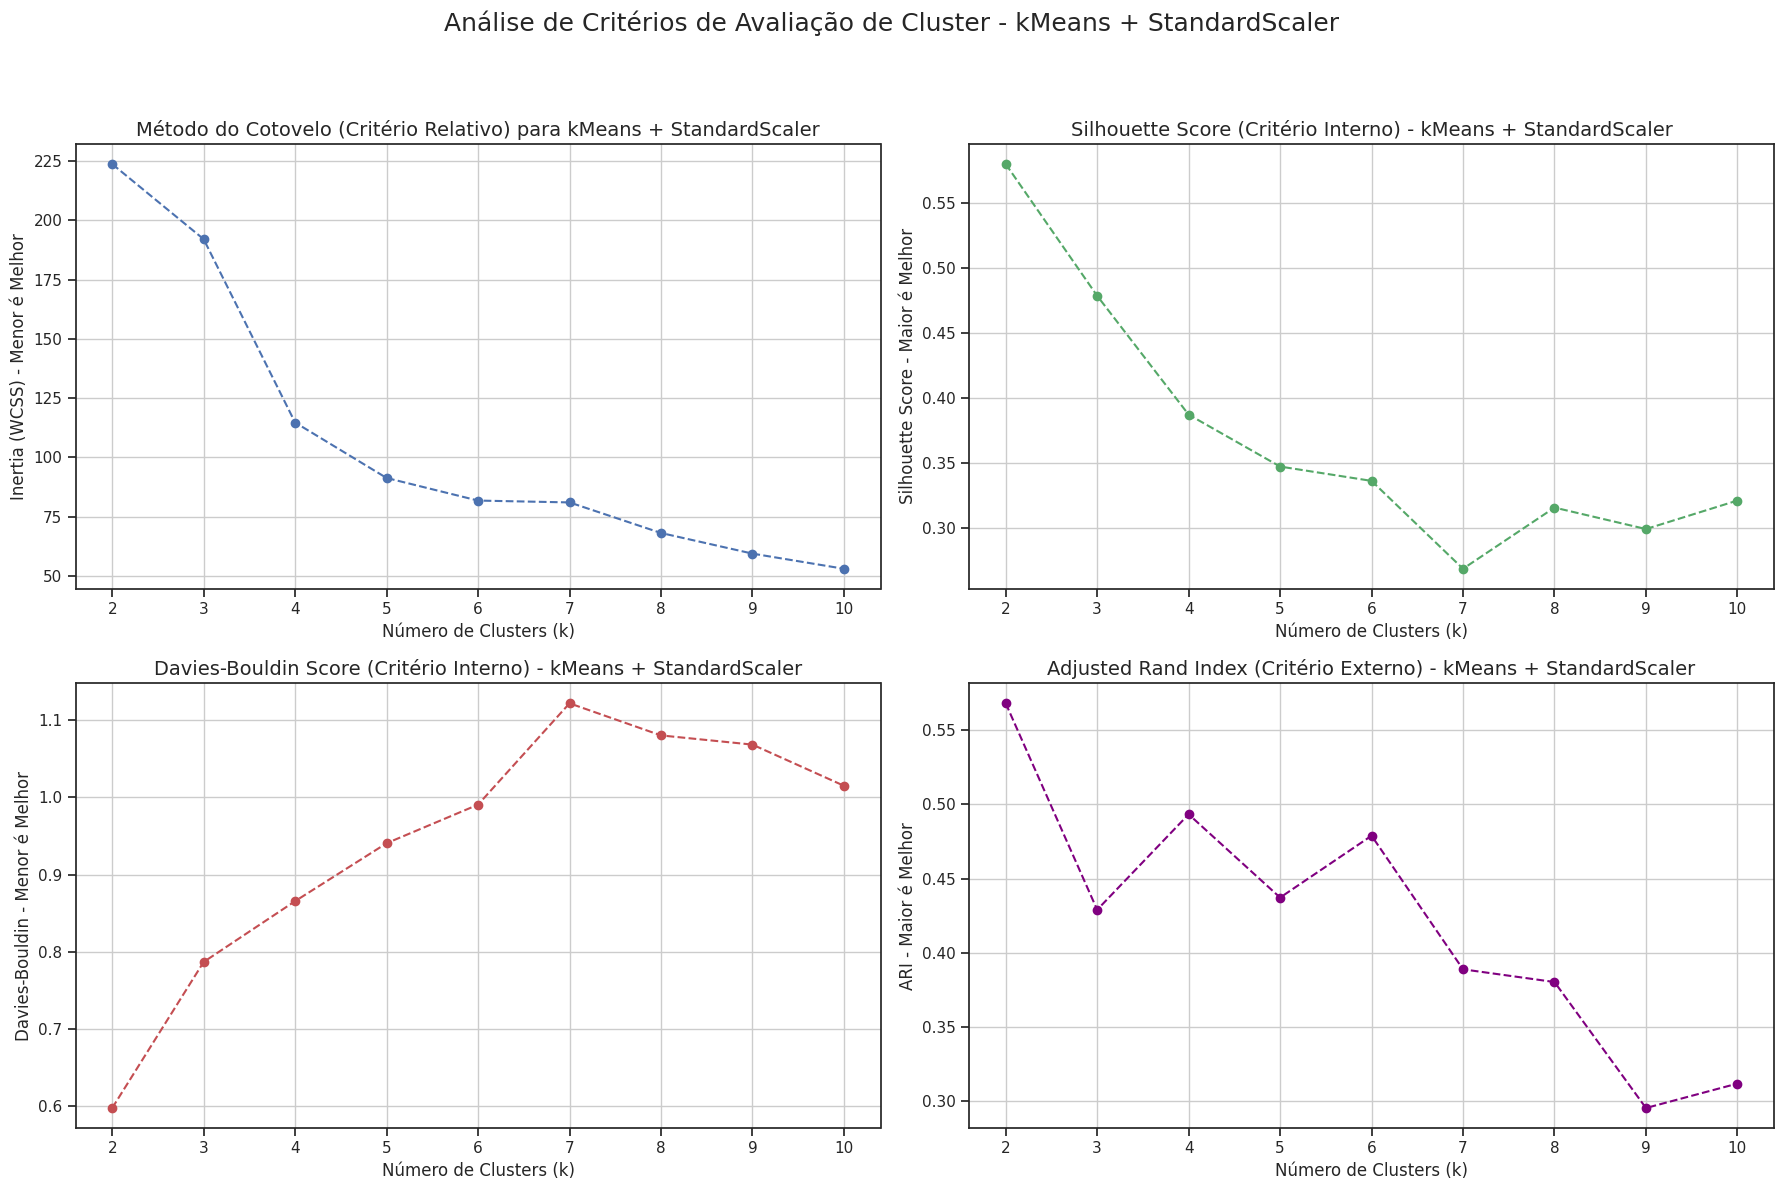

In [198]:
plot_clustering_evaluation(kmeans_evaluation,titulo="kMeans + StandardScaler" )

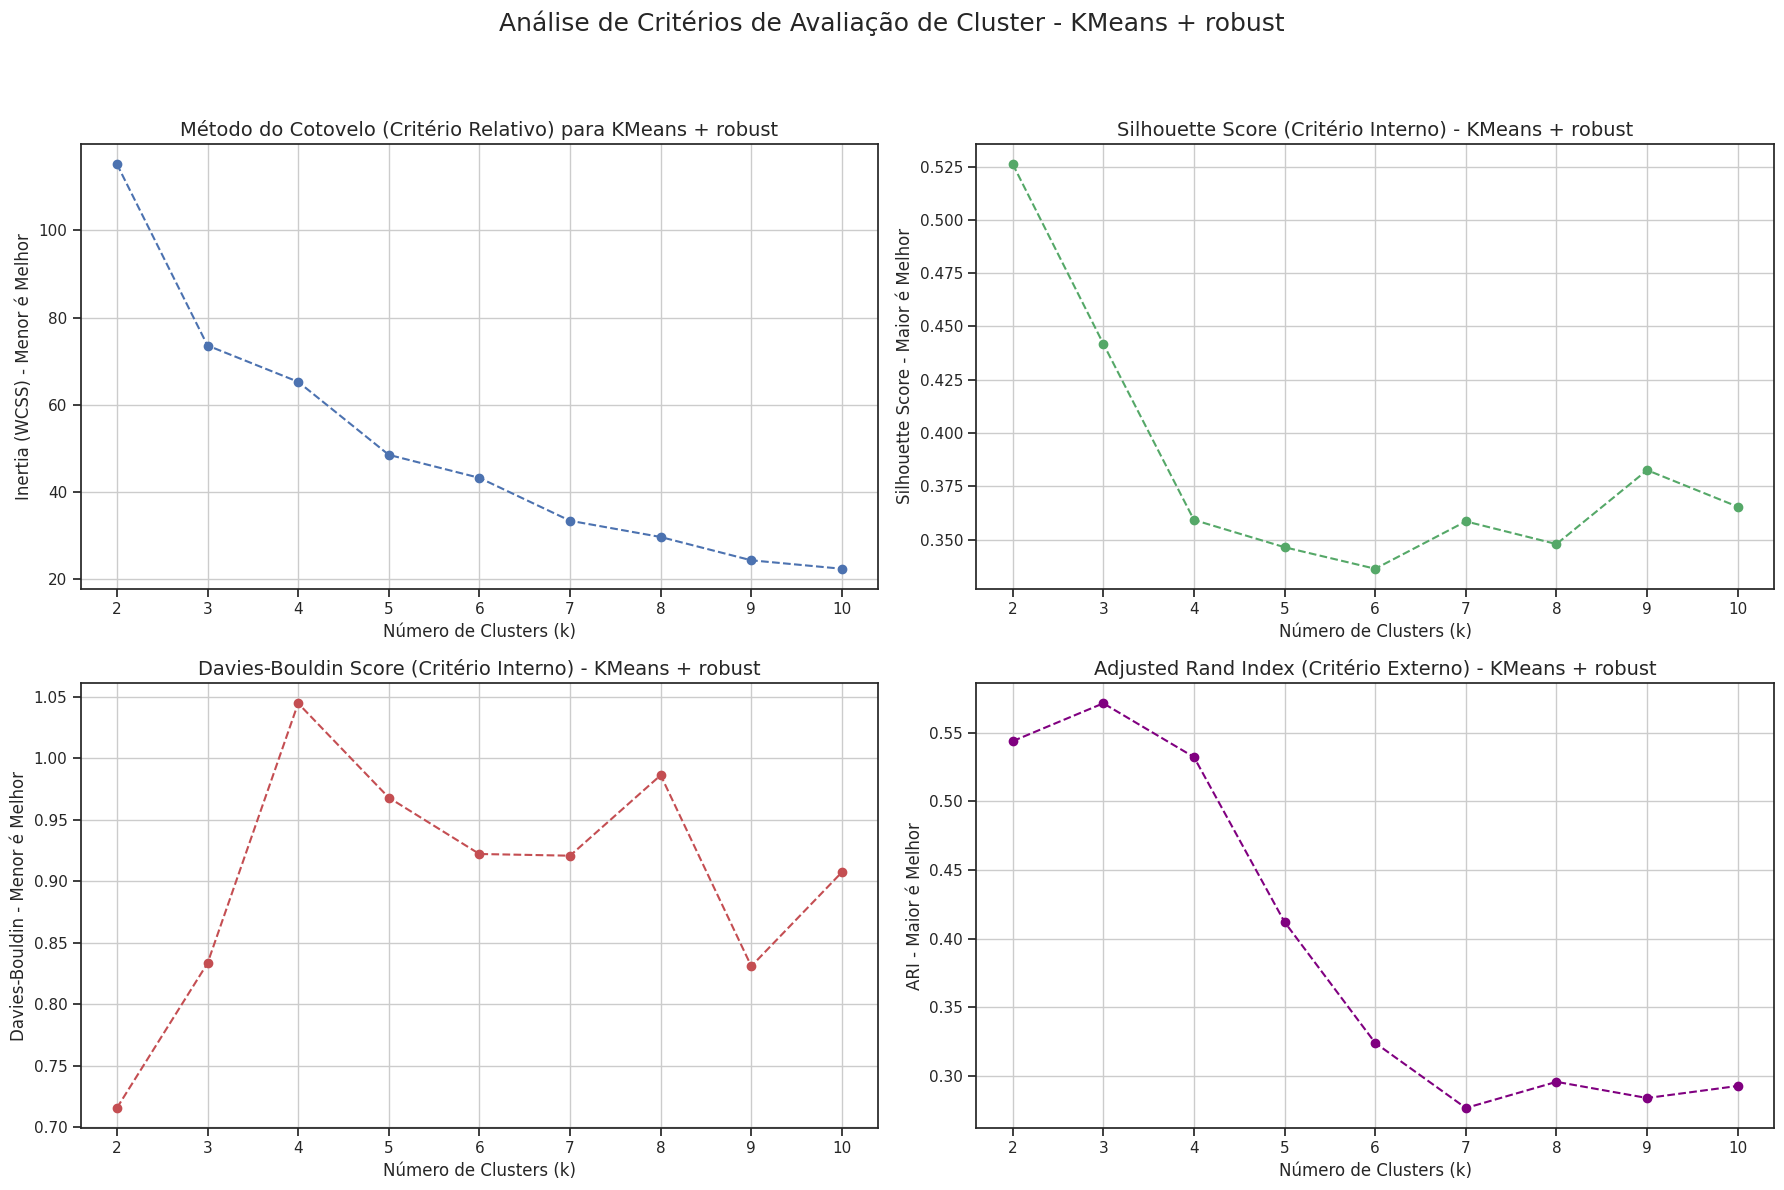

In [199]:
plot_clustering_evaluation(kmeans_evaluation_robust, titulo='KMeans + robust') #final_labels_robust, final_inertia_robust, final_model_robust

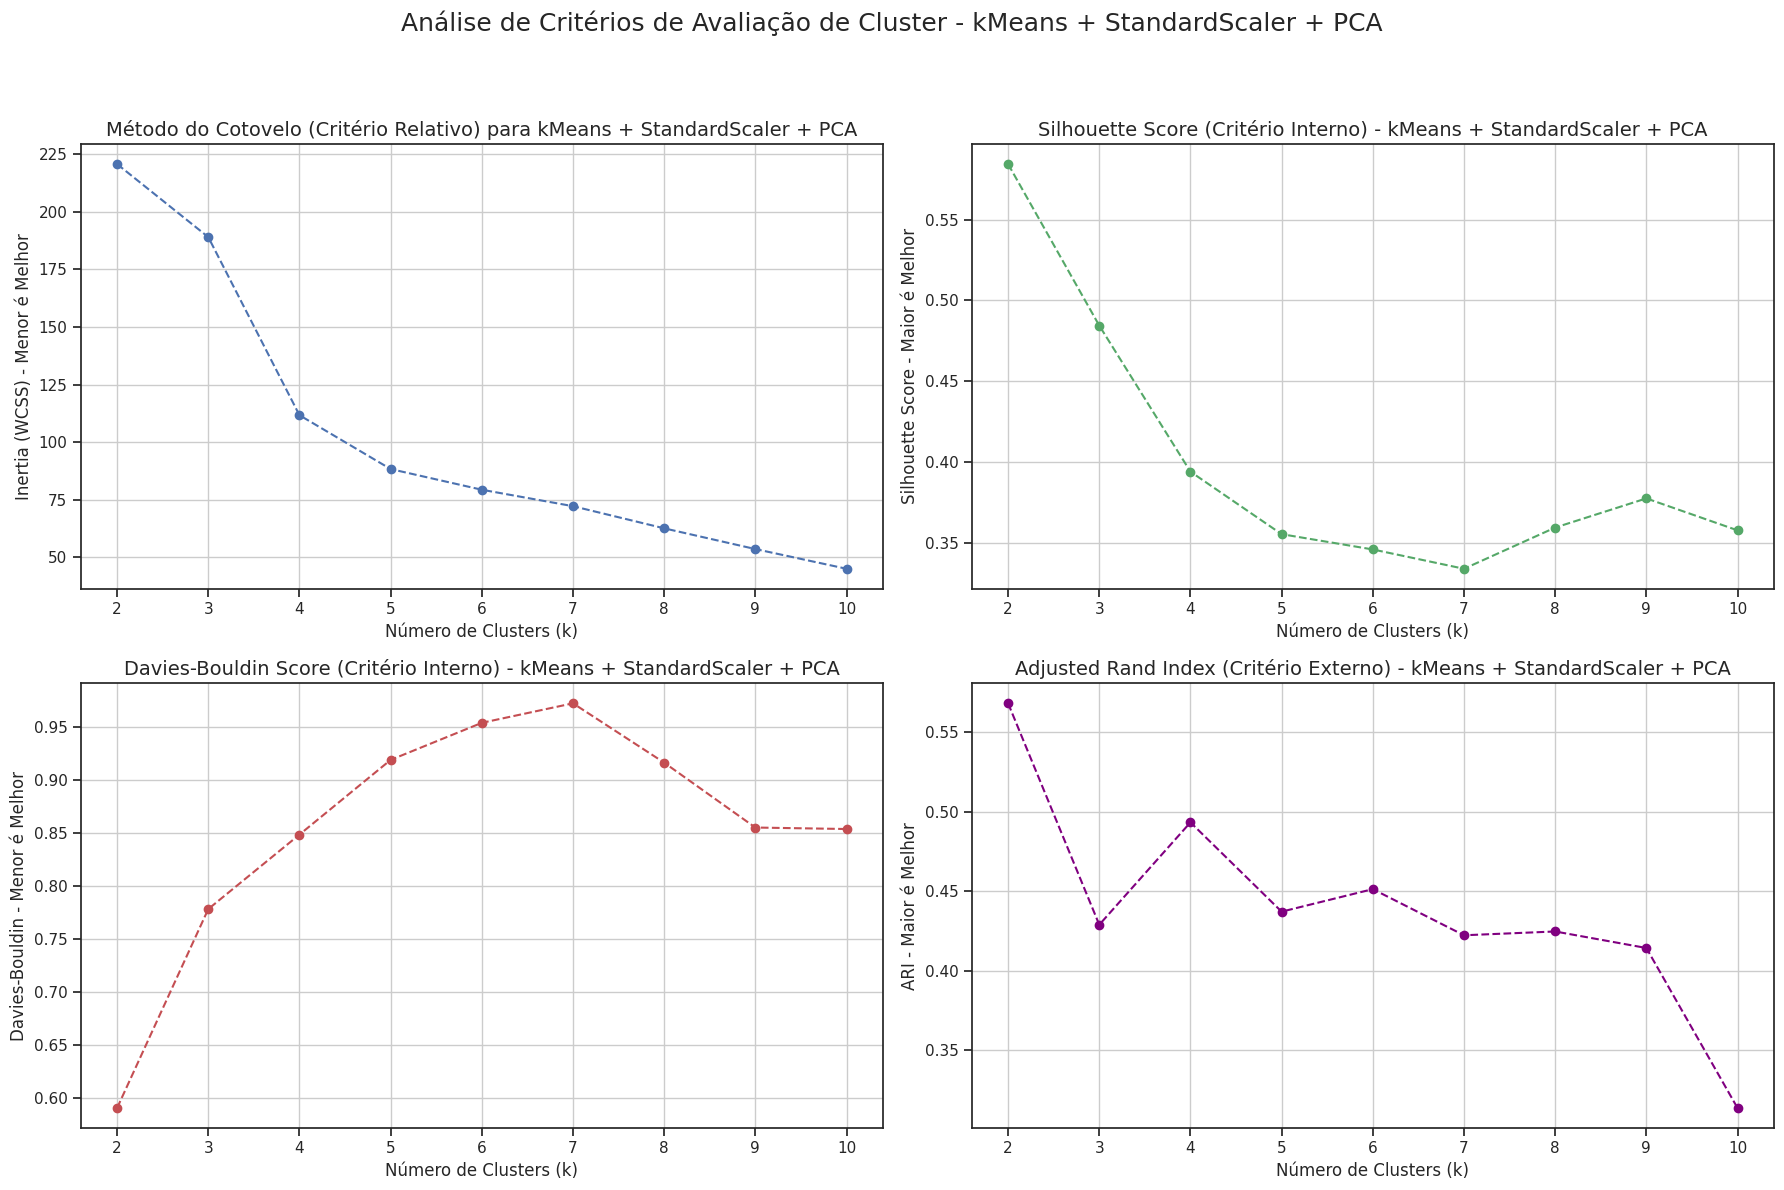

In [200]:
plot_clustering_evaluation(kmeans_evaluation_pca ,titulo="kMeans + StandardScaler + PCA" )

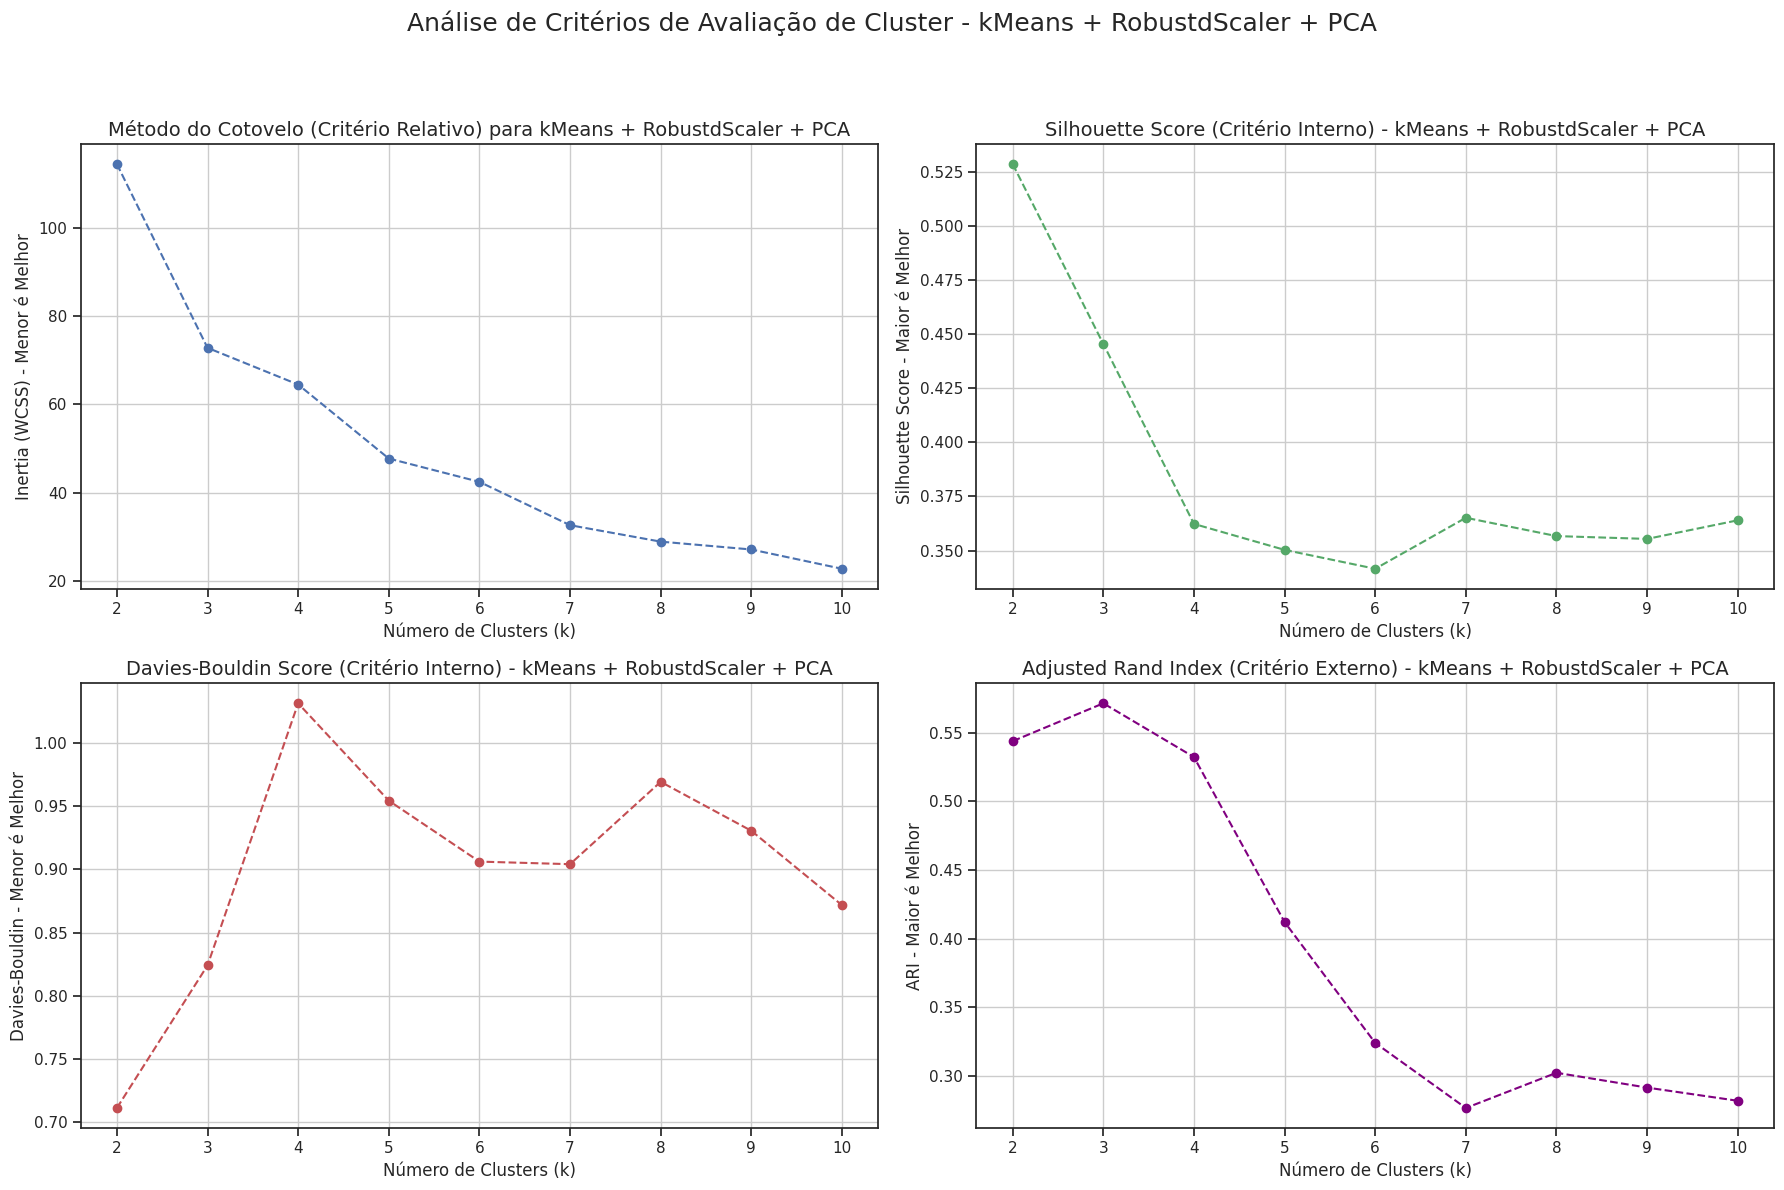

In [201]:
plot_clustering_evaluation(kmeans_evaluation_pca_robust ,titulo="kMeans + RobustdScaler + PCA" )

## Hcluster Plotss Criterio 

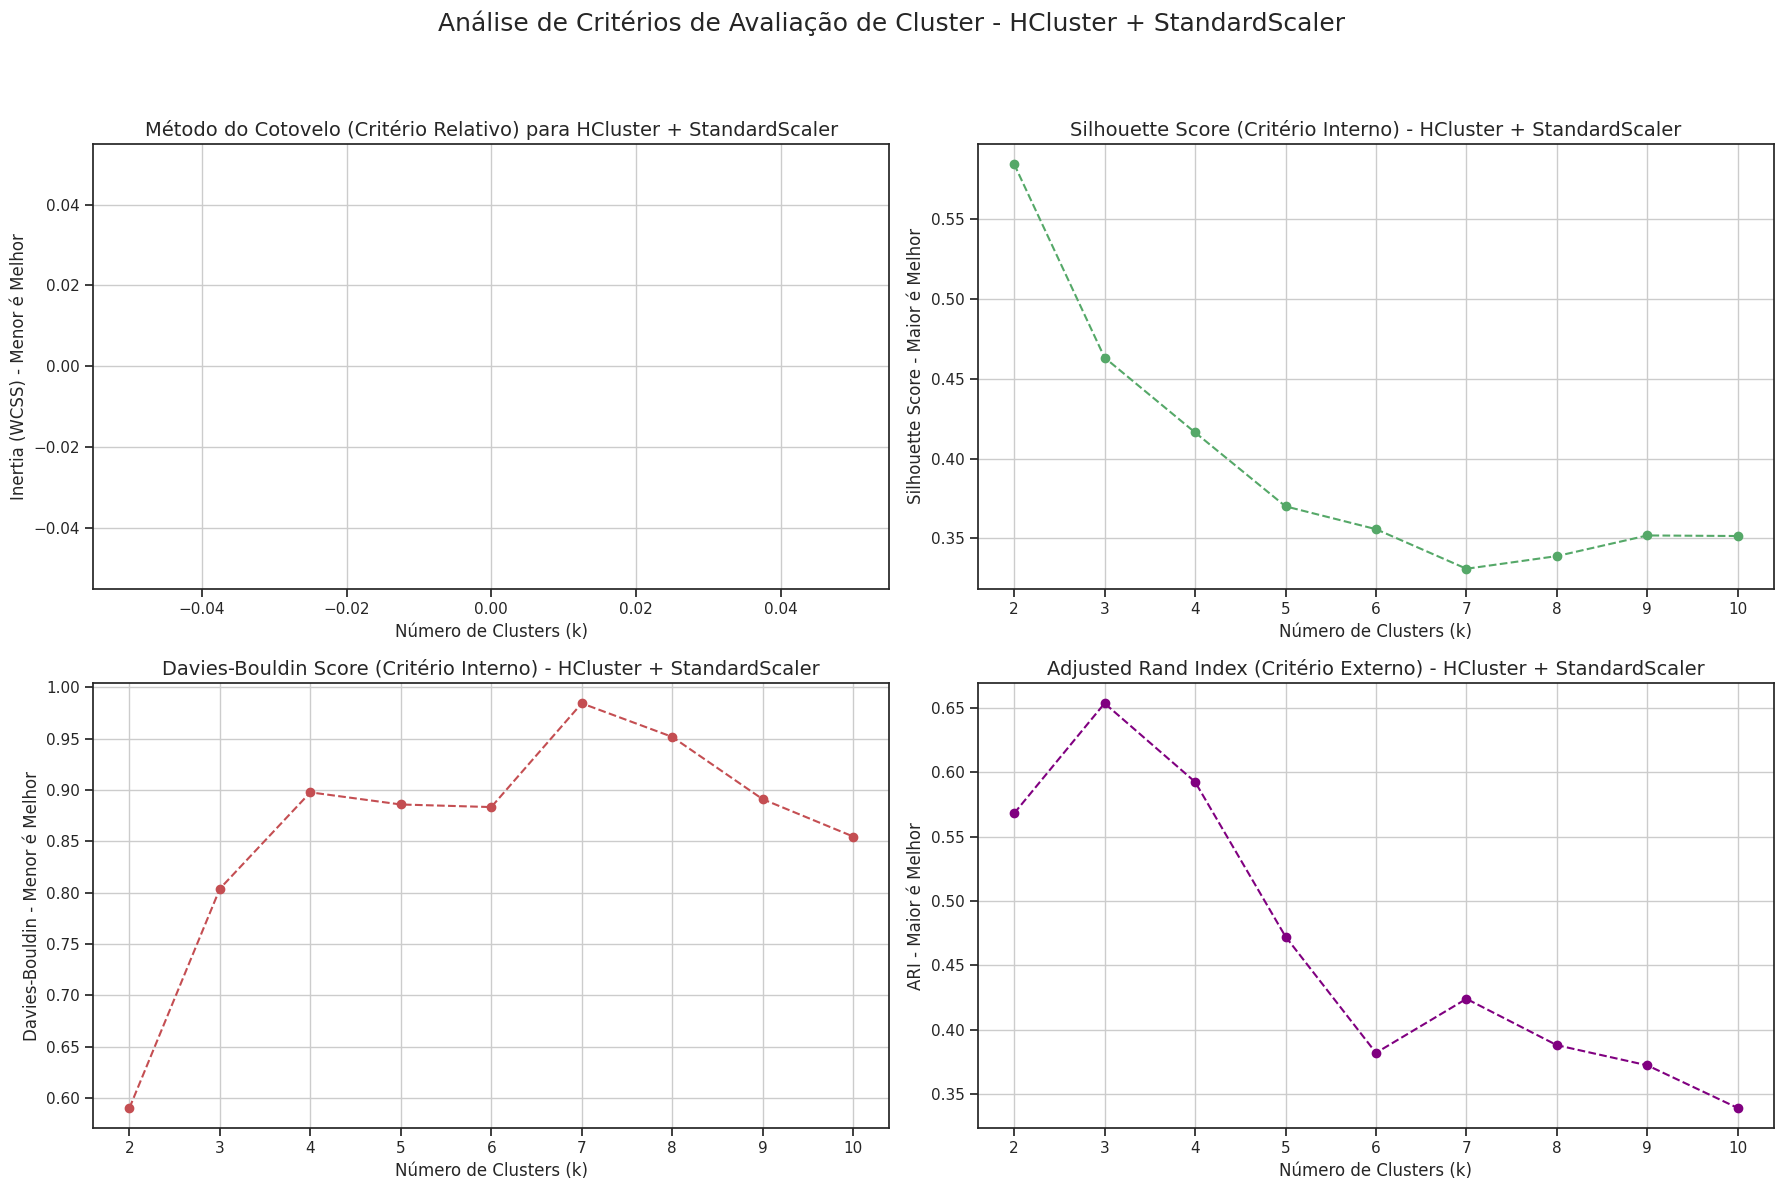

In [185]:
plot_clustering_evaluation(hcluster_evaluation, titulo='HCluster + StandardScaler')

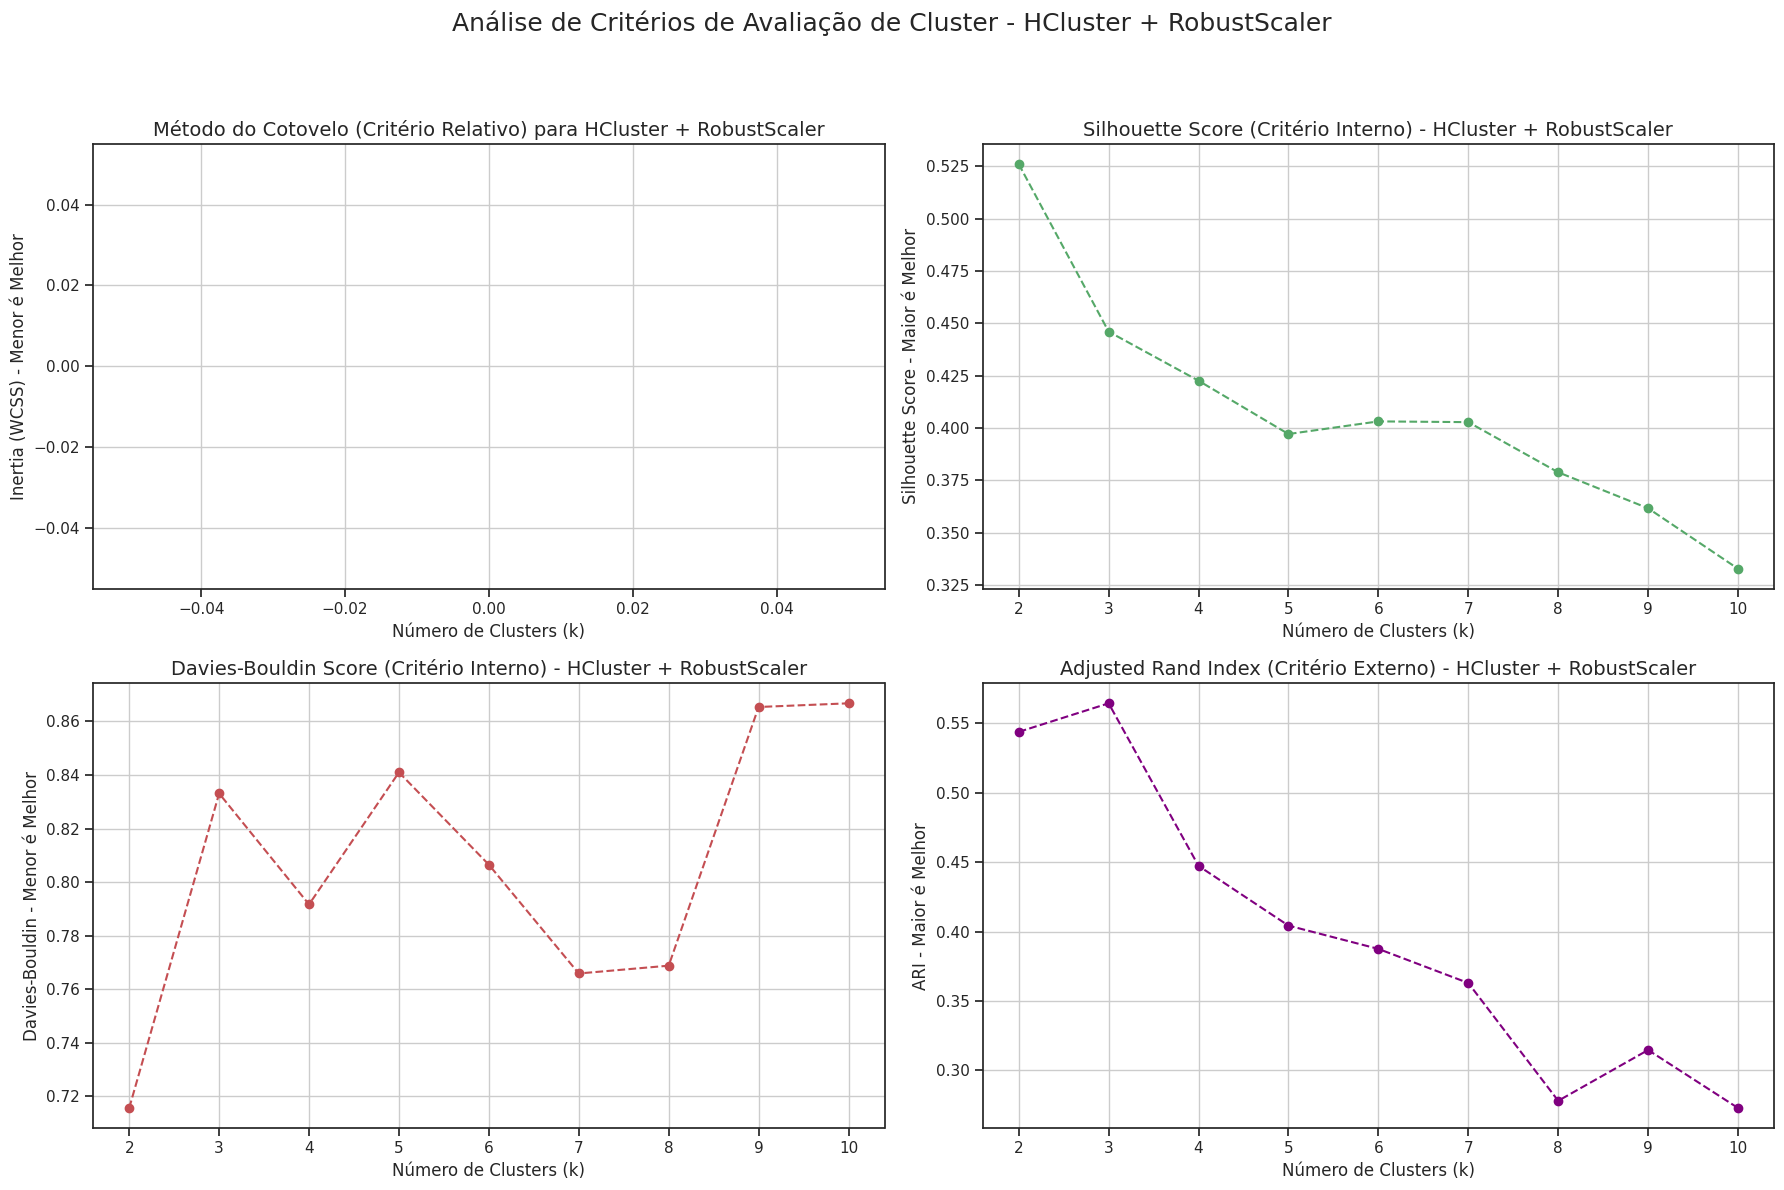

In [182]:
plot_clustering_evaluation(hcluster_evaluation_robust ,titulo="HCluster + RobustScaler" )

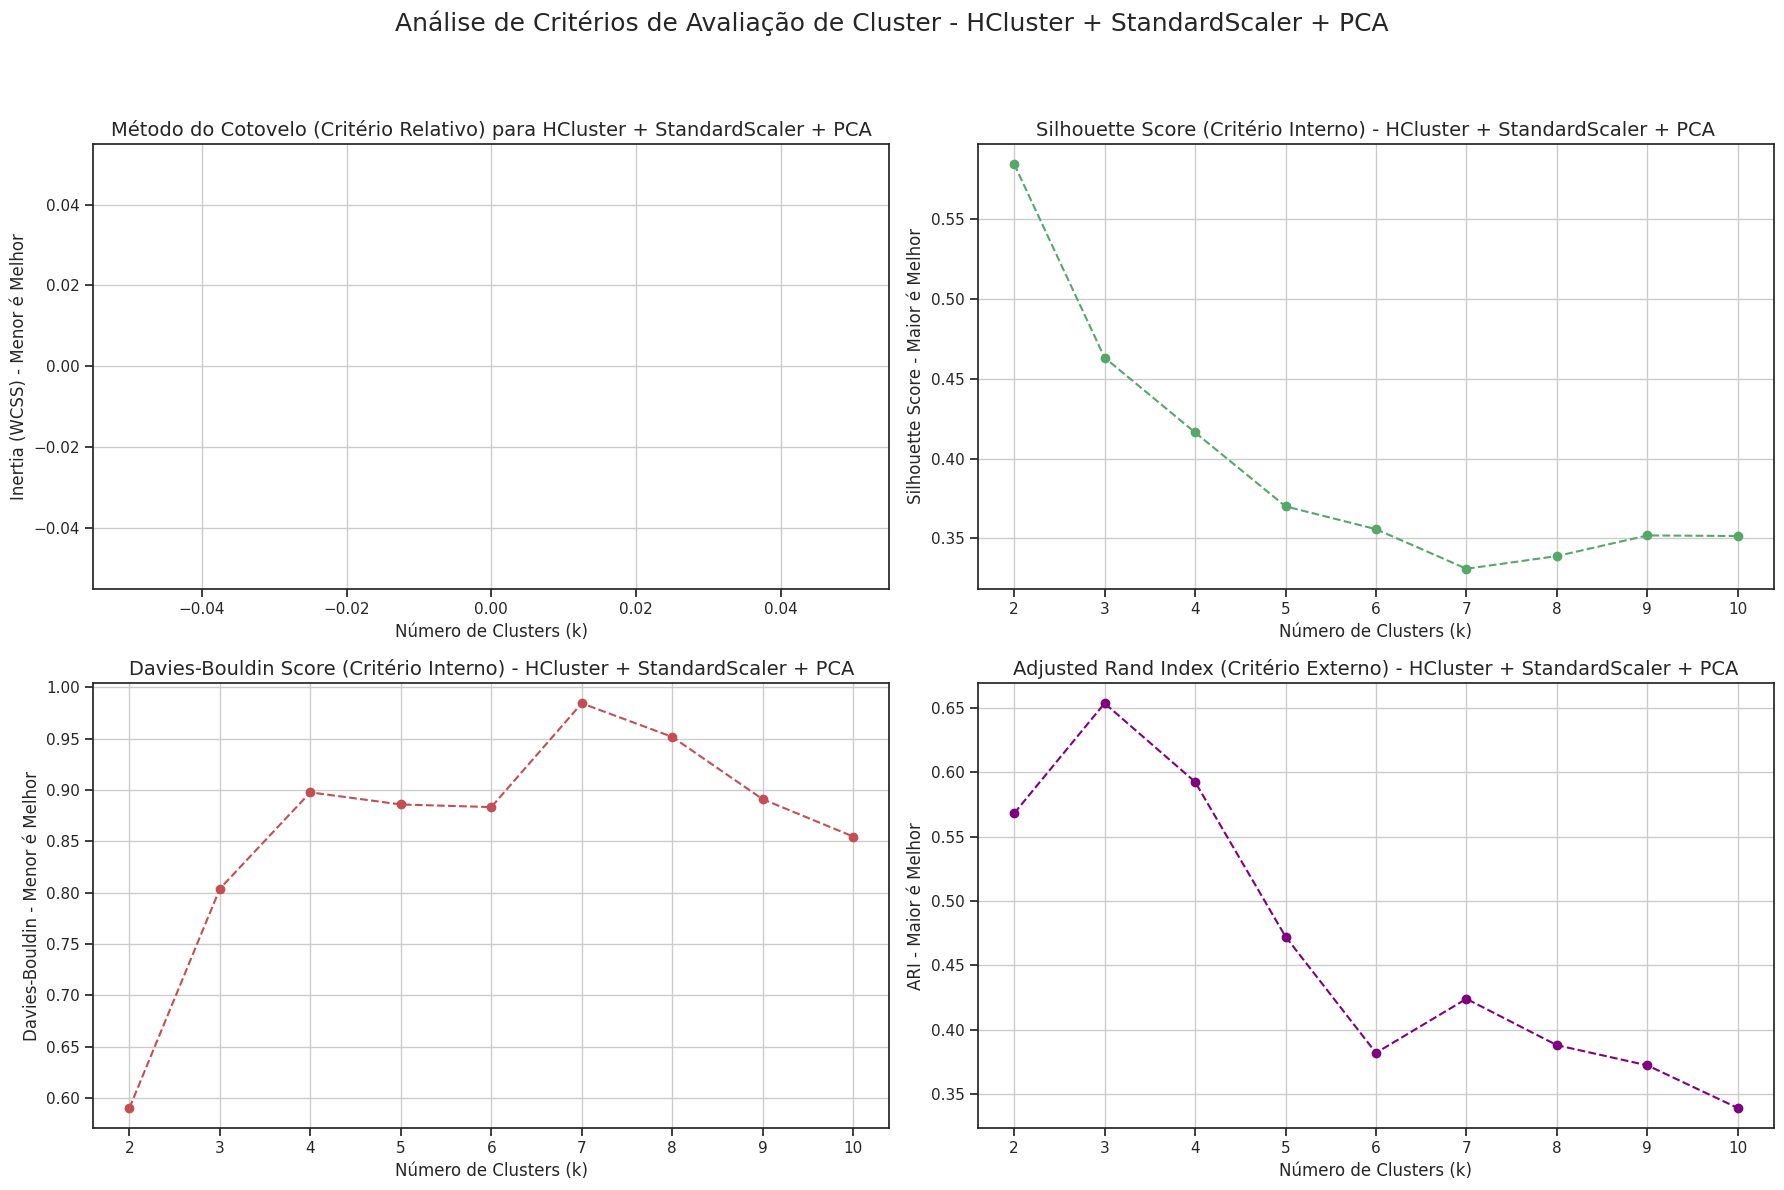

In [202]:
plot_clustering_evaluation(hcluster_evaluation_pca ,titulo="HCluster + StandardScaler + PCA" )

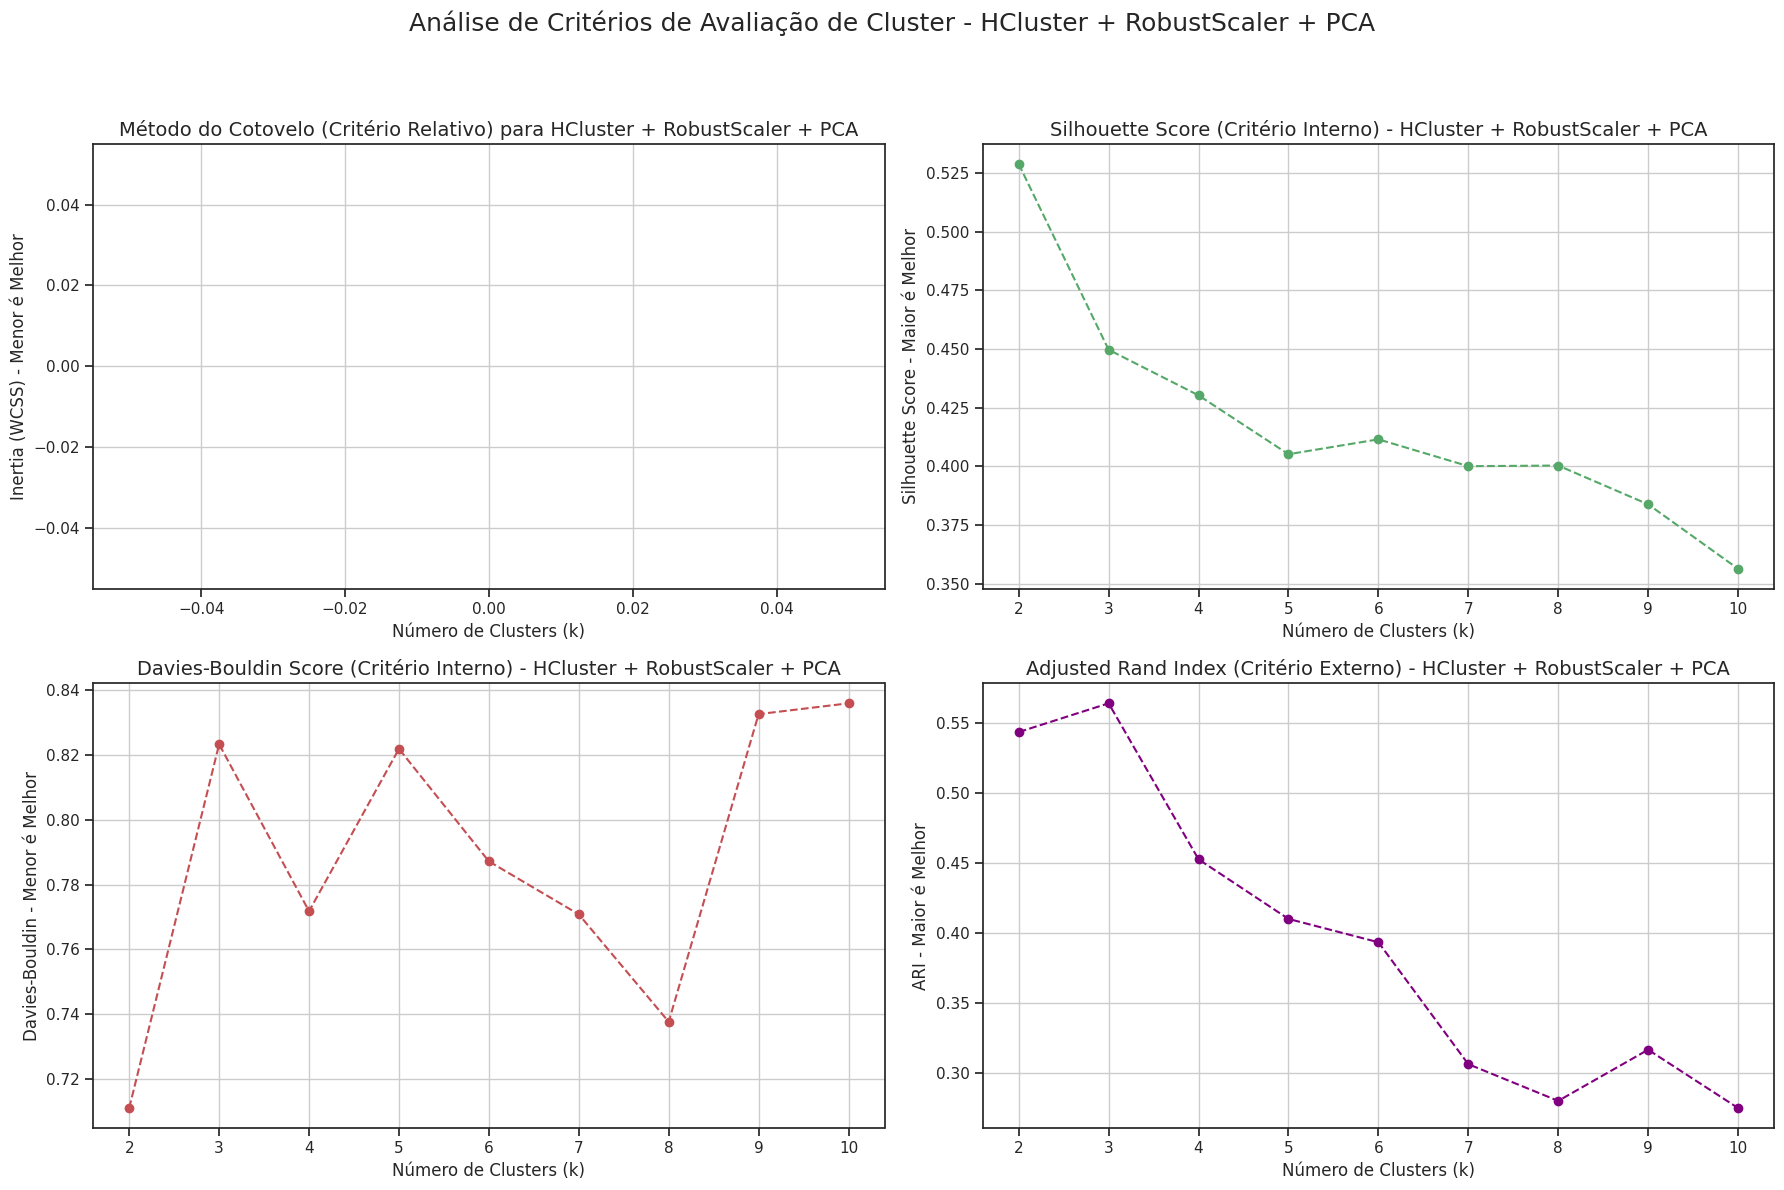

In [203]:
plot_clustering_evaluation(hcluster_evaluation_pca_robust ,titulo="HCluster + RobustScaler + PCA" )

### Métricas avaliação 

#### Para kmeans

In [204]:
# já com modelo treinado final para k=3
# e os 'final_labels' e 'y_true'

# Avaliar os clusters usando métricas de classificação
classification_results = evaluate_clustering_as_classification(y_true, final_labels)

# Exibir os resultados
print(f"Acurácia Mapeada: {classification_results['accuracy']:.4f}")

# Para ver precisão, recall e f1-score para cada classe
report_df = pd.DataFrame(classification_results['classification_report']).transpose()
print("\nRelatório de Classificação Detalhado:")
display(report_df)

# Para ver a tabela de confusão/contingência
print("\nTabela de Contingência (como os clusters foram mapeados):")
display(classification_results['contingency_matrix'])

Acurácia Mapeada: 0.6667

Relatório de Classificação Detalhado:


/home/alessandro/Documentos/academico/mestrado/2025/aprendizado-maquina/trabalho-002/trabalho2Env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/alessandro/Documentos/academico/mestrado/2025/aprendizado-maquina/trabalho-002/trabalho2Env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/alessandro/Documentos/academico/mestrado/2025/aprendizado-maquina/trabalho-002/trabalho2Env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricW

,precision,recall,f1-score,support
Iris-setosa,0.925926,1.000000,0.961538,50.000000
Iris-versicolor,0.000000,0.000000,0.000000,50.000000
Iris-virginica,0.520833,1.000000,0.684932,50.000000
accuracy,0.666667,0.666667,0.666667,0.666667
macro avg,0.482253,0.666667,0.548823,150.000000
weighted avg,0.482253,0.666667,0.548823,150.000000



Tabela de Contingência (como os clusters foram mapeados):


col_0,0,1,2
target,,,
Iris-setosa,0,32,18
Iris-versicolor,46,0,4
Iris-virginica,50,0,0


In [205]:
classification_results = evaluate_clustering_as_classification(y_true, final_labels_pca)


print(f"Acurácia Mapeada: {classification_results['accuracy']:.4f}")

# Para ver precisão, recall e f1-score para cada classe
report_df = pd.DataFrame(classification_results['classification_report']).transpose()

print("\nRelatório de Classificação Detalhado:")
display(report_df)

# Para ver a tabela de confusão/contingência
print("\nTabela de Contingência (como os clusters foram mapeados):")
display(classification_results['contingency_matrix'])

Acurácia Mapeada: 0.6667

Relatório de Classificação Detalhado:


/home/alessandro/Documentos/academico/mestrado/2025/aprendizado-maquina/trabalho-002/trabalho2Env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/alessandro/Documentos/academico/mestrado/2025/aprendizado-maquina/trabalho-002/trabalho2Env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/alessandro/Documentos/academico/mestrado/2025/aprendizado-maquina/trabalho-002/trabalho2Env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricW

,precision,recall,f1-score,support
Iris-setosa,0.925926,1.000000,0.961538,50.000000
Iris-versicolor,0.000000,0.000000,0.000000,50.000000
Iris-virginica,0.520833,1.000000,0.684932,50.000000
accuracy,0.666667,0.666667,0.666667,0.666667
macro avg,0.482253,0.666667,0.548823,150.000000
weighted avg,0.482253,0.666667,0.548823,150.000000



Tabela de Contingência (como os clusters foram mapeados):


col_0,0,1,2
target,,,
Iris-setosa,0,32,18
Iris-versicolor,46,0,4
Iris-virginica,50,0,0


In [206]:
classification_results = evaluate_clustering_as_classification(y_true, final_labels_robust)


print(f"Acurácia Mapeada: {classification_results['accuracy']:.4f}")

# Para ver precisão, recall e f1-score para cada classe
report_df = pd.DataFrame(classification_results['classification_report']).transpose()
print("\nRelatório de Classificação Detalhado:")
display(report_df)

# Para ver a tabela de confusão/contingência
print("\nTabela de Contingência (como os clusters foram mapeados):usando Kmeans + escalonamento por RobustScaler ")
display(classification_results['contingency_matrix'])

Acurácia Mapeada: 0.8067

Relatório de Classificação Detalhado:


,precision,recall,f1-score,support
Iris-setosa,1.000000,0.980000,0.989899,50.000000
Iris-versicolor,0.705882,0.720000,0.712871,50.000000
Iris-virginica,0.720000,0.720000,0.720000,50.000000
accuracy,0.806667,0.806667,0.806667,0.806667
macro avg,0.808627,0.806667,0.807590,150.000000
weighted avg,0.808627,0.806667,0.807590,150.000000



Tabela de Contingência (como os clusters foram mapeados):usando Kmeans + escalonamento por RobustScaler 


col_0,0,1,2
target,,,
Iris-setosa,0,1,49
Iris-versicolor,14,36,0
Iris-virginica,36,14,0


In [207]:
classification_results = evaluate_clustering_as_classification(y_true, final_labels_pca_robust)


print(f"Acurácia Mapeada: {classification_results['accuracy']:.4f}")

# Para ver precisão, recall e f1-score para cada classe
report_df = pd.DataFrame(classification_results['classification_report']).transpose()
print("\nRelatório de Classificação Detalhado:")
display(report_df)

# Para ver a tabela de confusão/contingência
print("\nTabela de Contingência (como os clusters foram mapeados):usando Kmeans + escalonamento por RobustScaler + PCA ")
display(classification_results['contingency_matrix'])

Acurácia Mapeada: 0.8067

Relatório de Classificação Detalhado:


,precision,recall,f1-score,support
Iris-setosa,1.000000,0.980000,0.989899,50.000000
Iris-versicolor,0.705882,0.720000,0.712871,50.000000
Iris-virginica,0.720000,0.720000,0.720000,50.000000
accuracy,0.806667,0.806667,0.806667,0.806667
macro avg,0.808627,0.806667,0.807590,150.000000
weighted avg,0.808627,0.806667,0.807590,150.000000



Tabela de Contingência (como os clusters foram mapeados):usando Kmeans + escalonamento por RobustScaler + PCA 


col_0,0,1,2
target,,,
Iris-setosa,0,1,49
Iris-versicolor,14,36,0
Iris-virginica,36,14,0


#### Para hcluster

In [208]:
final_labels_hc
# já com modelo treinado final para k_hc=3
# e os 'final_labels_hc' e 'y_true'

# Avaliar os clusters usando métricas de classificação
classification_results = evaluate_clustering_as_classification(y_true, final_labels_hc)

# Exibir os resultados
print(f"Acurácia Mapeada: {classification_results['accuracy']:.4f}")

# Para ver precisão, recall e f1-score para cada classe
report_df = pd.DataFrame(classification_results['classification_report']).transpose()
print("\nRelatório de Classificação Detalhado:")
display(report_df)

# Para ver a tabela de confusão/contingência
print("\nTabela de Contingência (como os clusters HCluestr foram mapeados):")
display(classification_results['contingency_matrix'])

Acurácia Mapeada: 0.8267

Relatório de Classificação Detalhado:


,precision,recall,f1-score,support
Iris-setosa,1.000000,0.980000,0.989899,50.000000
Iris-versicolor,0.900000,0.540000,0.675000,50.000000
Iris-virginica,0.676056,0.960000,0.793388,50.000000
accuracy,0.826667,0.826667,0.826667,0.826667
macro avg,0.858685,0.826667,0.819429,150.000000
weighted avg,0.858685,0.826667,0.819429,150.000000



Tabela de Contingência (como os clusters HCluestr foram mapeados):


col_0,0,1,2
target,,,
Iris-setosa,0,49,1
Iris-versicolor,23,0,27
Iris-virginica,48,0,2


In [209]:
final_labels_hc
# já com modelo treinado final para k_hc=3
# e os 'final_labels_hc' e 'y_true'

# Avaliar os clusters usando métricas de classificação
classification_results = evaluate_clustering_as_classification(y_true, final_labels_hc_pca)

# Exibir os resultados
print(f"Acurácia Mapeada: {classification_results['accuracy']:.4f}")

# Para ver precisão, recall e f1-score para cada classe
report_df = pd.DataFrame(classification_results['classification_report']).transpose()
print("\nRelatório de Classificação Detalhado:")
display(report_df)

# Para ver a tabela de confusão/contingência
print("\nTabela de Contingência (como os clusters HCluestr foram mapeados): com pca ")
display(classification_results['contingency_matrix'])

Acurácia Mapeada: 0.8467

Relatório de Classificação Detalhado:


,precision,recall,f1-score,support
Iris-setosa,1.000000,1.000000,1.000000,50.000000
Iris-versicolor,0.684932,1.000000,0.813008,50.000000
Iris-virginica,1.000000,0.540000,0.701299,50.000000
accuracy,0.846667,0.846667,0.846667,0.846667
macro avg,0.894977,0.846667,0.838102,150.000000
weighted avg,0.894977,0.846667,0.838102,150.000000



Tabela de Contingência (como os clusters HCluestr foram mapeados):


col_0,0,1,2
target,,,
Iris-setosa,0,50,0
Iris-versicolor,50,0,0
Iris-virginica,23,0,27


In [210]:
final_labels_hc
# já com modelo treinado final para k_hc=3
# e os 'final_labels_hc' e 'y_true'

# Avaliar os clusters usando métricas de classificação
classification_results = evaluate_clustering_as_classification(y_true, final_labels_hc_robust)

# Exibir os resultados
print(f"Acurácia Mapeada: {classification_results['accuracy']:.4f}")

# Para ver precisão, recall e f1-score para cada classe
report_df = pd.DataFrame(classification_results['classification_report']).transpose()
print("\nRelatório de Classificação Detalhado:")
display(report_df)

# Para ver a tabela de confusão/contingência
print("\nTabela de Contingência (como os clusters HCluestr foram mapeados): com pca ")
display(classification_results['contingency_matrix'])

Acurácia Mapeada: 0.8000

Relatório de Classificação Detalhado:


,precision,recall,f1-score,support
Iris-setosa,1.000000,0.98,0.989899,50.0
Iris-versicolor,0.661290,0.82,0.732143,50.0
Iris-virginica,0.769231,0.60,0.674157,50.0
accuracy,0.800000,0.80,0.800000,0.8
macro avg,0.810174,0.80,0.798733,150.0
weighted avg,0.810174,0.80,0.798733,150.0



Tabela de Contingência (como os clusters HCluestr foram mapeados): com pca 


col_0,0,1,2
target,,,
Iris-setosa,49,1,0
Iris-versicolor,0,41,9
Iris-virginica,0,20,30


In [211]:
final_labels_hc
# já com modelo treinado final para k_hc=3
# e os 'final_labels_hc' e 'y_true'

# Avaliar os clusters usando métricas de classificação
classification_results = evaluate_clustering_as_classification(y_true, final_labels_hc_pca_robust)

# Exibir os resultados
print(f"Acurácia Mapeada: {classification_results['accuracy']:.4f}")

# Para ver precisão, recall e f1-score para cada classe
report_df = pd.DataFrame(classification_results['classification_report']).transpose()
print("\nRelatório de Classificação Detalhado:")
display(report_df)

# Para ver a tabela de confusão/contingência
print("\nTabela de Contingência (como os clusters HCluestr foram mapeados): com pca ")
display(classification_results['contingency_matrix'])

Acurácia Mapeada: 0.8000

Relatório de Classificação Detalhado:


,precision,recall,f1-score,support
Iris-setosa,1.000000,0.98,0.989899,50.0
Iris-versicolor,0.661290,0.82,0.732143,50.0
Iris-virginica,0.769231,0.60,0.674157,50.0
accuracy,0.800000,0.80,0.800000,0.8
macro avg,0.810174,0.80,0.798733,150.0
weighted avg,0.810174,0.80,0.798733,150.0



Tabela de Contingência (como os clusters HCluestr foram mapeados): com pca 


col_0,0,1,2
target,,,
Iris-setosa,49,1,0
Iris-versicolor,0,41,9
Iris-virginica,0,20,30


In [239]:
def exibir_resultados_classificacao(y_true, predicted_labels, descricao=''):
    """
    Avalia e exibe as métricas de classificação entre rótulos reais e rótulos previstos de clustering.

    Parâmetros:
    - y_true: rótulos verdadeiros
    - predicted_labels: rótulos do clustering
    - descricao: texto adicional para identificar o modelo
    """
    results = evaluate_clustering_as_classification(y_true, predicted_labels)

    print(f"\n📌 Avaliação: {descricao}")
    print(f"Acurácia Mapeada: {results['accuracy']:.4f}")

    print("\n📊 Relatório de Classificação Detalhado:")
    display(pd.DataFrame(results['classification_report']).transpose())

    print("\n🧩 Tabela de Contingência:")
    display(results['contingency_matrix'])

    return results


In [240]:
def avaliar_varios_modelos(y_true, modelos_labels_dict):
    """
    Avalia múltiplas predições de clustering e retorna resultados em dicionário.

    Parâmetros:
    - y_true: rótulos reais
    - modelos_labels_dict: dicionário com {nome_modelo: rótulos_preditos}

    Retorna:
    - dict com {nome_modelo: resultados_classificacao}
    """
    resultados = {}
    for nome_modelo, labels_preditos in modelos_labels_dict.items():
        resultados[nome_modelo] = exibir_resultados_classificacao(
            y_true, labels_preditos, descricao=nome_modelo
        )
    return resultados

In [247]:
def gerar_ranking_modelos(resultados_dict):
    """
    Gera um DataFrame com as métricas globais (accuracy, f1, recall, precision)
    de todos os modelos avaliados, ordenado por f1, accuracy, recall e precision.
    F1 mais importante, depois acuracia e sucessivamente.

    Parâmetros:
    - resultados_dict: dicionário retornado por `avaliar_varios_modelos()`

    Retorna:
    - DataFrame ordenado do melhor para o pior modelo
    """
    ranking_data = []

    for nome_modelo, resultado in resultados_dict.items():
        report = resultado["classification_report"]
        # As métricas médias ponderadas ("weighted avg") são as mais representativas no geral
        weighted_avg = report.get("weighted avg", {})
        ranking_data.append({
            "modelo": nome_modelo,
            "f1_score": weighted_avg.get("f1-score", 0),
            "accuracy": resultado.get("accuracy", 0),
            "recall": weighted_avg.get("recall", 0),
            "precision": weighted_avg.get("precision", 0),
        })

    ranking_df = pd.DataFrame(ranking_data)
    ranking_df = ranking_df.sort_values(
        by=["f1_score", "accuracy", "recall", "precision"], ascending=False
    ).reset_index(drop=True)

    return ranking_df


In [248]:
# Dicionário de rótulos gerados por diferentes técnicas de clustering
modelos_labels_dict = {
    "KMeans": final_labels,
    "KMeans + PCA": final_labels_pca,
    "KMeans + Robust": final_labels_robust,
    "KMeans + PCA + Robust": final_labels_pca_robust,
    "HC": final_labels_hc,
    "HC + PCA": final_labels_hc_pca,
    "HC + Robust": final_labels_hc_robust,
    "HC + PCA + Robust": final_labels_hc_pca_robust,
}

In [249]:
# Executa a avaliação para todos os modelos
resultados_todos = avaliar_varios_modelos(y_true, modelos_labels_dict)


📌 Avaliação: KMeans
Acurácia Mapeada: 0.6667

📊 Relatório de Classificação Detalhado:


/home/alessandro/Documentos/academico/mestrado/2025/aprendizado-maquina/trabalho-002/trabalho2Env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/alessandro/Documentos/academico/mestrado/2025/aprendizado-maquina/trabalho-002/trabalho2Env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/alessandro/Documentos/academico/mestrado/2025/aprendizado-maquina/trabalho-002/trabalho2Env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricW

,precision,recall,f1-score,support
Iris-setosa,0.925926,1.000000,0.961538,50.000000
Iris-versicolor,0.000000,0.000000,0.000000,50.000000
Iris-virginica,0.520833,1.000000,0.684932,50.000000
accuracy,0.666667,0.666667,0.666667,0.666667
macro avg,0.482253,0.666667,0.548823,150.000000
weighted avg,0.482253,0.666667,0.548823,150.000000



🧩 Tabela de Contingência:


col_0,0,1,2
target,,,
Iris-setosa,0,32,18
Iris-versicolor,46,0,4
Iris-virginica,50,0,0



📌 Avaliação: KMeans + PCA
Acurácia Mapeada: 0.6667

📊 Relatório de Classificação Detalhado:


/home/alessandro/Documentos/academico/mestrado/2025/aprendizado-maquina/trabalho-002/trabalho2Env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/alessandro/Documentos/academico/mestrado/2025/aprendizado-maquina/trabalho-002/trabalho2Env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/alessandro/Documentos/academico/mestrado/2025/aprendizado-maquina/trabalho-002/trabalho2Env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricW

,precision,recall,f1-score,support
Iris-setosa,0.925926,1.000000,0.961538,50.000000
Iris-versicolor,0.000000,0.000000,0.000000,50.000000
Iris-virginica,0.520833,1.000000,0.684932,50.000000
accuracy,0.666667,0.666667,0.666667,0.666667
macro avg,0.482253,0.666667,0.548823,150.000000
weighted avg,0.482253,0.666667,0.548823,150.000000



🧩 Tabela de Contingência:


col_0,0,1,2
target,,,
Iris-setosa,0,32,18
Iris-versicolor,46,0,4
Iris-virginica,50,0,0



📌 Avaliação: KMeans + Robust
Acurácia Mapeada: 0.8067

📊 Relatório de Classificação Detalhado:


,precision,recall,f1-score,support
Iris-setosa,1.000000,0.980000,0.989899,50.000000
Iris-versicolor,0.705882,0.720000,0.712871,50.000000
Iris-virginica,0.720000,0.720000,0.720000,50.000000
accuracy,0.806667,0.806667,0.806667,0.806667
macro avg,0.808627,0.806667,0.807590,150.000000
weighted avg,0.808627,0.806667,0.807590,150.000000



🧩 Tabela de Contingência:


col_0,0,1,2
target,,,
Iris-setosa,0,1,49
Iris-versicolor,14,36,0
Iris-virginica,36,14,0



📌 Avaliação: KMeans + PCA + Robust
Acurácia Mapeada: 0.8067

📊 Relatório de Classificação Detalhado:


,precision,recall,f1-score,support
Iris-setosa,1.000000,0.980000,0.989899,50.000000
Iris-versicolor,0.705882,0.720000,0.712871,50.000000
Iris-virginica,0.720000,0.720000,0.720000,50.000000
accuracy,0.806667,0.806667,0.806667,0.806667
macro avg,0.808627,0.806667,0.807590,150.000000
weighted avg,0.808627,0.806667,0.807590,150.000000



🧩 Tabela de Contingência:


col_0,0,1,2
target,,,
Iris-setosa,0,1,49
Iris-versicolor,14,36,0
Iris-virginica,36,14,0



📌 Avaliação: HC
Acurácia Mapeada: 0.8267

📊 Relatório de Classificação Detalhado:


,precision,recall,f1-score,support
Iris-setosa,1.000000,0.980000,0.989899,50.000000
Iris-versicolor,0.900000,0.540000,0.675000,50.000000
Iris-virginica,0.676056,0.960000,0.793388,50.000000
accuracy,0.826667,0.826667,0.826667,0.826667
macro avg,0.858685,0.826667,0.819429,150.000000
weighted avg,0.858685,0.826667,0.819429,150.000000



🧩 Tabela de Contingência:


col_0,0,1,2
target,,,
Iris-setosa,0,49,1
Iris-versicolor,23,0,27
Iris-virginica,48,0,2



📌 Avaliação: HC + PCA
Acurácia Mapeada: 0.8467

📊 Relatório de Classificação Detalhado:


,precision,recall,f1-score,support
Iris-setosa,1.000000,1.000000,1.000000,50.000000
Iris-versicolor,0.684932,1.000000,0.813008,50.000000
Iris-virginica,1.000000,0.540000,0.701299,50.000000
accuracy,0.846667,0.846667,0.846667,0.846667
macro avg,0.894977,0.846667,0.838102,150.000000
weighted avg,0.894977,0.846667,0.838102,150.000000



🧩 Tabela de Contingência:


col_0,0,1,2
target,,,
Iris-setosa,0,50,0
Iris-versicolor,50,0,0
Iris-virginica,23,0,27



📌 Avaliação: HC + Robust
Acurácia Mapeada: 0.8000

📊 Relatório de Classificação Detalhado:


,precision,recall,f1-score,support
Iris-setosa,1.000000,0.98,0.989899,50.0
Iris-versicolor,0.661290,0.82,0.732143,50.0
Iris-virginica,0.769231,0.60,0.674157,50.0
accuracy,0.800000,0.80,0.800000,0.8
macro avg,0.810174,0.80,0.798733,150.0
weighted avg,0.810174,0.80,0.798733,150.0



🧩 Tabela de Contingência:


col_0,0,1,2
target,,,
Iris-setosa,49,1,0
Iris-versicolor,0,41,9
Iris-virginica,0,20,30



📌 Avaliação: HC + PCA + Robust
Acurácia Mapeada: 0.8000

📊 Relatório de Classificação Detalhado:


,precision,recall,f1-score,support
Iris-setosa,1.000000,0.98,0.989899,50.0
Iris-versicolor,0.661290,0.82,0.732143,50.0
Iris-virginica,0.769231,0.60,0.674157,50.0
accuracy,0.800000,0.80,0.800000,0.8
macro avg,0.810174,0.80,0.798733,150.0
weighted avg,0.810174,0.80,0.798733,150.0



🧩 Tabela de Contingência:


col_0,0,1,2
target,,,
Iris-setosa,49,1,0
Iris-versicolor,0,41,9
Iris-virginica,0,20,30


In [252]:
resultados =gerar_ranking_modelos(resultados_todos)
resultados

,modelo,f1_score,accuracy,recall,precision
0,HC + PCA,0.838102,0.846667,0.846667,0.894977
1,HC,0.819429,0.826667,0.826667,0.858685
2,KMeans + Robust,0.807590,0.806667,0.806667,0.808627
3,KMeans + PCA + Robust,0.807590,0.806667,0.806667,0.808627
4,HC + Robust,0.798733,0.800000,0.800000,0.810174
5,HC + PCA + Robust,0.798733,0.800000,0.800000,0.810174
6,KMeans,0.548823,0.666667,0.666667,0.482253
7,KMeans + PCA,0.548823,0.666667,0.666667,0.482253


## Geral Avaliação dos modelos

In [ ]:
av_modelos = {""}

## Verificação de relevância do conhecimento

# Aplicação

## Apresentação de resultados

In [172]:
def plotar_clusters_com_tsne(X_scaled, labels):
    """
    Aplica t-SNE para reduzir a dimensionalidade e plota os clusters em 2D.

    Args:
        X_scaled (np.ndarray): Dados originais padronizados.
        labels (np.ndarray): Rótulos de cluster para colorir os pontos.
    """
    # 1. Instanciar o t-SNE.
    # --- CORREÇÃO AQUI ---
    # O parâmetro 'n_iter' foi substituído por 'max_iter' em versões recentes.
    tsne = TSNE(n_components=2, perplexity=30, random_state=42, max_iter=1000)

    # 2. Aplicar o t-SNE aos dados
    print("Calculando a projeção t-SNE... (isso pode levar um momento)")
    X_tsne = tsne.fit_transform(X_scaled)
    print("Projeção concluída.")

    # 3. Criar um DataFrame para facilitar a plotagem com Seaborn
    df_tsne = pd.DataFrame({
        'tsne-1': X_tsne[:, 0],
        'tsne-2': X_tsne[:, 1],
        'cluster': labels
    })

    # 4. Plotar o resultado
    plt.figure(figsize=(12, 8))
    sns.scatterplot(
        x='tsne-1', y='tsne-2',
        hue='cluster',
        palette='viridis',
        data=df_tsne,
        s=100,
        alpha=0.9,
        legend='full'
    )

    plt.title('Clusters Visualizados com t-SNE', fontsize=16)
    plt.xlabel('Componente t-SNE 1', fontsize=12)
    plt.ylabel('Componente t-SNE 2', fontsize=12)
    plt.legend(title='Cluster ID')
    plt.grid(True)
    plt.show()

In [159]:
def plotar_grafo_similaridade(X_scaled, labels, n_vizinhos=5,modelo=""):
    """
    Cria e plota um grafo de similaridade onde os nós são coloridos pelos seus labels.

    Args:
        X_scaled (np.ndarray): Dados padronizados.
        labels (np.ndarray): Rótulos de cluster para colorir os nós.
        n_vizinhos (int): Número de vizinhos mais próximos para conectar cada nó.
    """
    # 1. Cria um grafo de conectividade com base nos k-vizinhos mais próximos
    knn_graph = kneighbors_graph(X_scaled, n_neighbors=n_vizinhos, mode='connectivity', include_self=False)

    # 2. Cria o objeto do grafo a partir da matriz de adjacência do KNN
    G = nx.from_scipy_sparse_array(knn_graph)

    # 3. Define as cores para cada nó com base no seu rótulo de cluster
    cores_mapa = {0: 'gold', 1: 'blue', 2: 'green'} # Mapeia cluster ID para cor
    cores_nos = [cores_mapa.get(label, 'grey') for label in labels]

    # 4. Calcula a posição dos nós para uma visualização agradável
    pos = nx.spring_layout(G, seed=42)

    # 5. Plota o grafo
    plt.figure(figsize=(14, 10))
    nx.draw(
        G,
        pos,
        node_color=cores_nos,
        with_labels=False,
        node_size=80,
        width=0.5, # Espessura das arestas
        alpha=0.8
    )
    plt.title(f'Grafo de Similaridade (k-NN com k={n_vizinhos} -MOdelo: {modelo} )', fontsize=16)
    plt.show()

### GRAFO

Essa é uma dúvida excelente e muito importante! A resposta é que o n_neighbors do grafo e o n_clusters do K-Means são parâmetros fundamentalmente diferentes que medem coisas distintas.

Confundi-los é muito comum, mas entender a diferença é a chave para interpretar o grafo corretamente.


Característica 	n_clusters = 3 (no K-Means/H-Cluster) 	n_neighbors = 5 (no Grafo de Similaridade)


O que é?	|   Número de Grupos	Número de Conexões Locais

Pergunta que Responde | "Em quantos 'países' o meu mapa de dados se divide?" |	"Para cada 'cidadão' (ponto), quem são seus vizinhos de porta mais próximos?"

Escopo da Medida |	Global: É uma propriedade do dataset inteiro. |	Local: É uma propriedade de cada ponto individualmente.
    
Objetivo	| Particionar todo o conjunto de dados em 3 grupos distintos. |	Construir uma "teia de conexões" para revelar a estrutura e a forma como os dados estão distribuídos.




Em resumo, n_clusters=3 é a hipótese que estamos testando sobre a estrutura geral dos dados. n_neighbors=5 é a ferramenta que usamos para desenhar as conexões locais e visualizar essa estrutura.

Por que Usamos n_neighbors=5 (e não 3)?
O objetivo de criar o grafo não é forçar a existência de 3 grupos, mas sim revelar a estrutura de vizinhança que já existe nos dados. O número de vizinhos que escolhemos afeta a "resolução" do nosso desenho:

Se n_neighbors for muito baixo (ex: 1 ou 2): O grafo fica "quebrado" e esparso, com muitos pontos isolados ou em pares. É como desenhar apenas algumas estradas principais, você não consegue ver como os bairros se conectam.
Se n_neighbors for muito alto (ex: 20): O grafo se torna um "emaranhado" denso de conexões. Quase todos os pontos se conectam com muitos outros, e a estrutura de clusters fica escondida na poluição visual. É como desenhar uma estrada de cada casa para todas as outras casas da cidade.
O valor de n_neighbors=5 é um bom ponto de partida empírico. Ele geralmente é suficiente para conectar os pontos que realmente pertencem ao mesmo cluster, mas não é tão alto a ponto de criar muitas conexões entre clusters diferentes.

Como Interpretar o Grafo Gerado com n_neighbors=5
Agora, a parte mais importante. Ao olhar para o grafo, você deve procurar por:

Formação de "Ilhas" (Comunidades): O objetivo principal é observar a formação de "comunidades" de nós que são densamente conectados entre si, mas que têm poucas conexões com os nós de outras comunidades. Idealmente, você verá 3 ilhas principais.

Cores Dentro das Ilhas: Se o seu clustering (K-Means ou H-Cluster) funcionou bem, cada uma dessas "ilhas" deve ser majoritariamente monocromática. Ou seja, uma ilha verde (setosa), uma ilha azul e uma ilha amarela.

"Pontes" Entre as Ilhas: As poucas arestas (linhas) que conectam nós de cores diferentes são as mais interessantes. Elas representam os pontos de fronteira, ou seja, os dados que estão na zona de confusão entre dois clusters. No seu caso, você deve esperar ver:

A ilha verde (setosa) muito bem definida e com pouquíssimas ou nenhuma ponte para as outras.
As ilhas azul e amarela (versicolor e virginica) mais próximas uma da outra e com um número maior de "pontes" entre elas. Isso visualiza perfeitamente a sobreposição que vimos nas outras análises.
Portanto, o grafo não usa k=3 para ser construído, mas o resultado do grafo deve, idealmente, revelar a estrutura de 3 clusters que você encontrou com os outros métodos.

Calculando a projeção t-SNE... (isso pode levar um momento)
Projeção concluída.


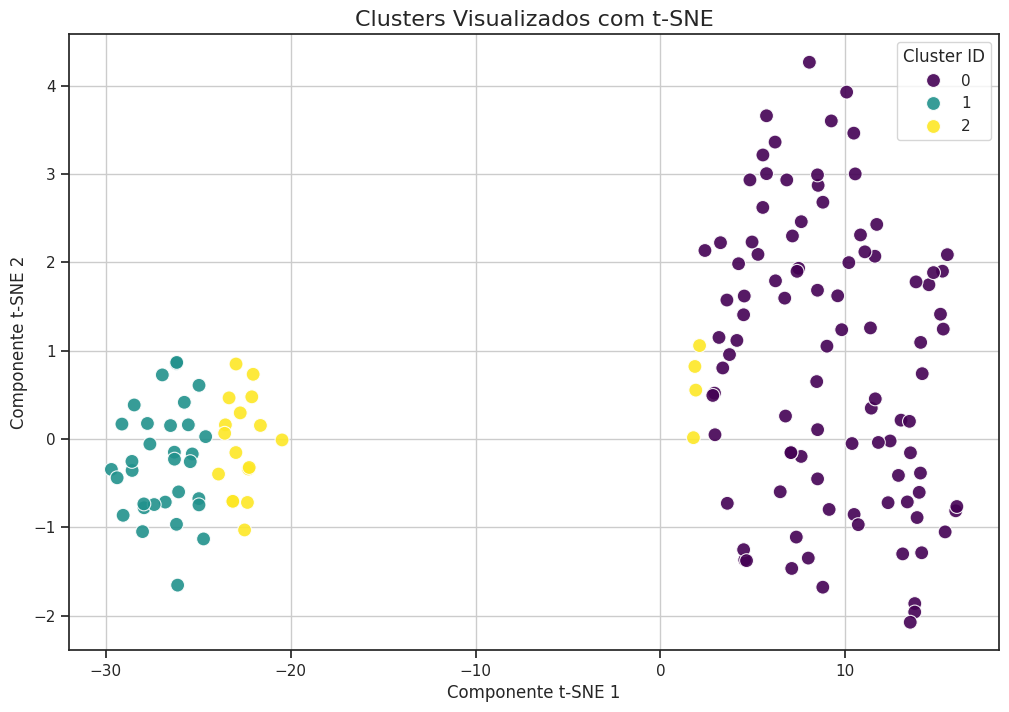

In [173]:
plotar_clusters_com_tsne(X_scaled, final_labels)

#### Para kmeans

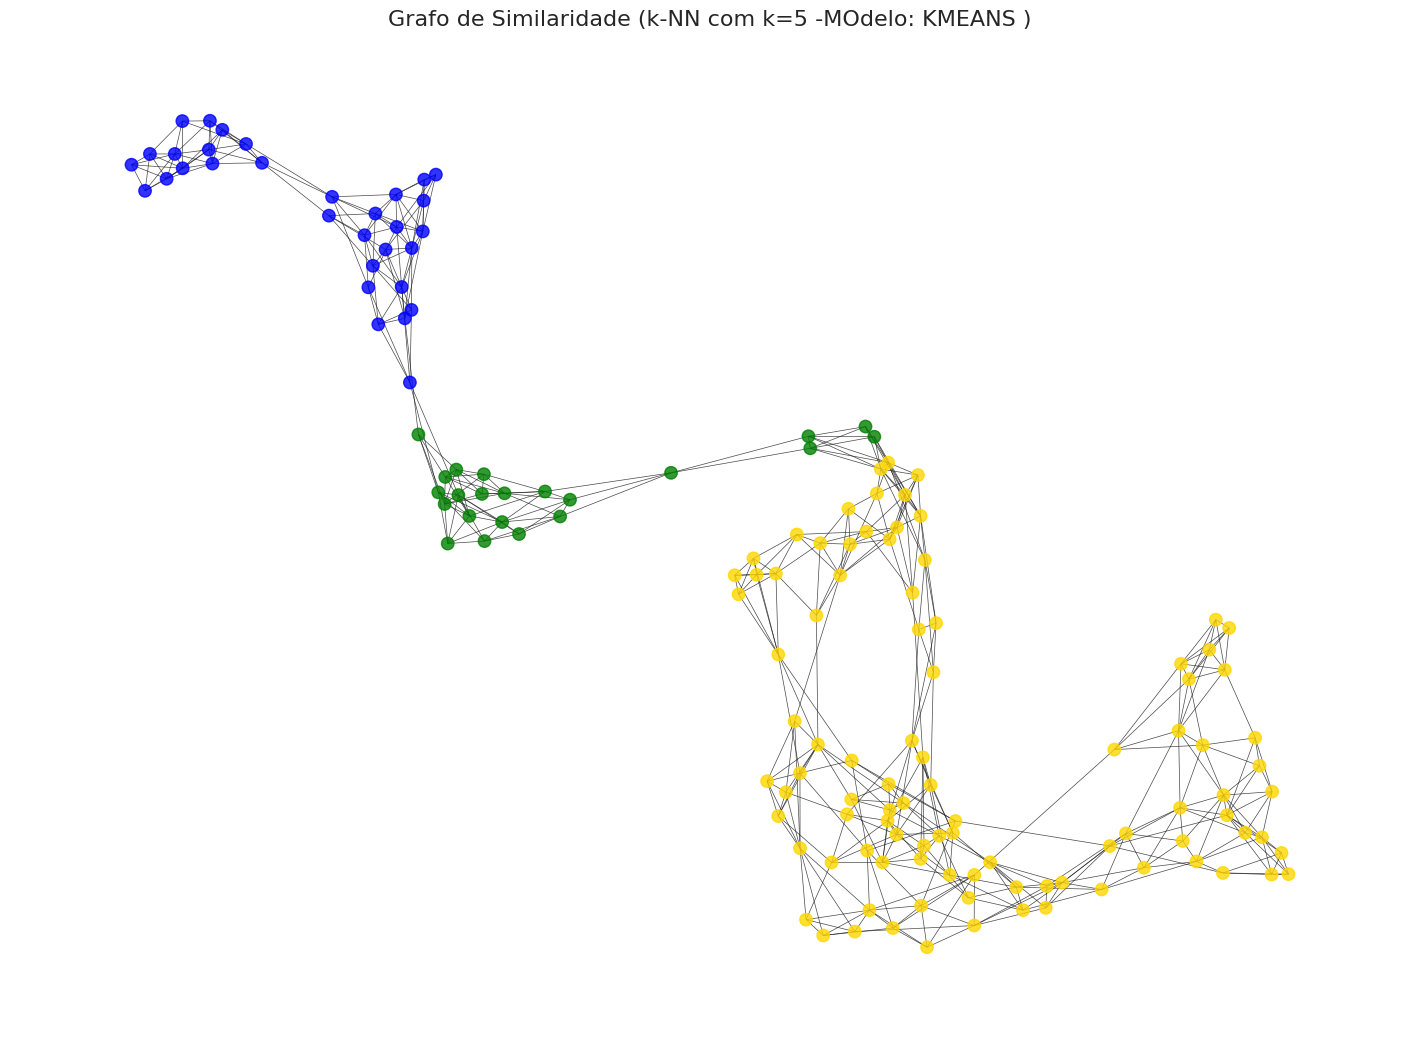

In [160]:
plotar_grafo_similaridade(X_scaled, final_labels, n_vizinhos=5,modelo="KMEANS")

#### para HCluster

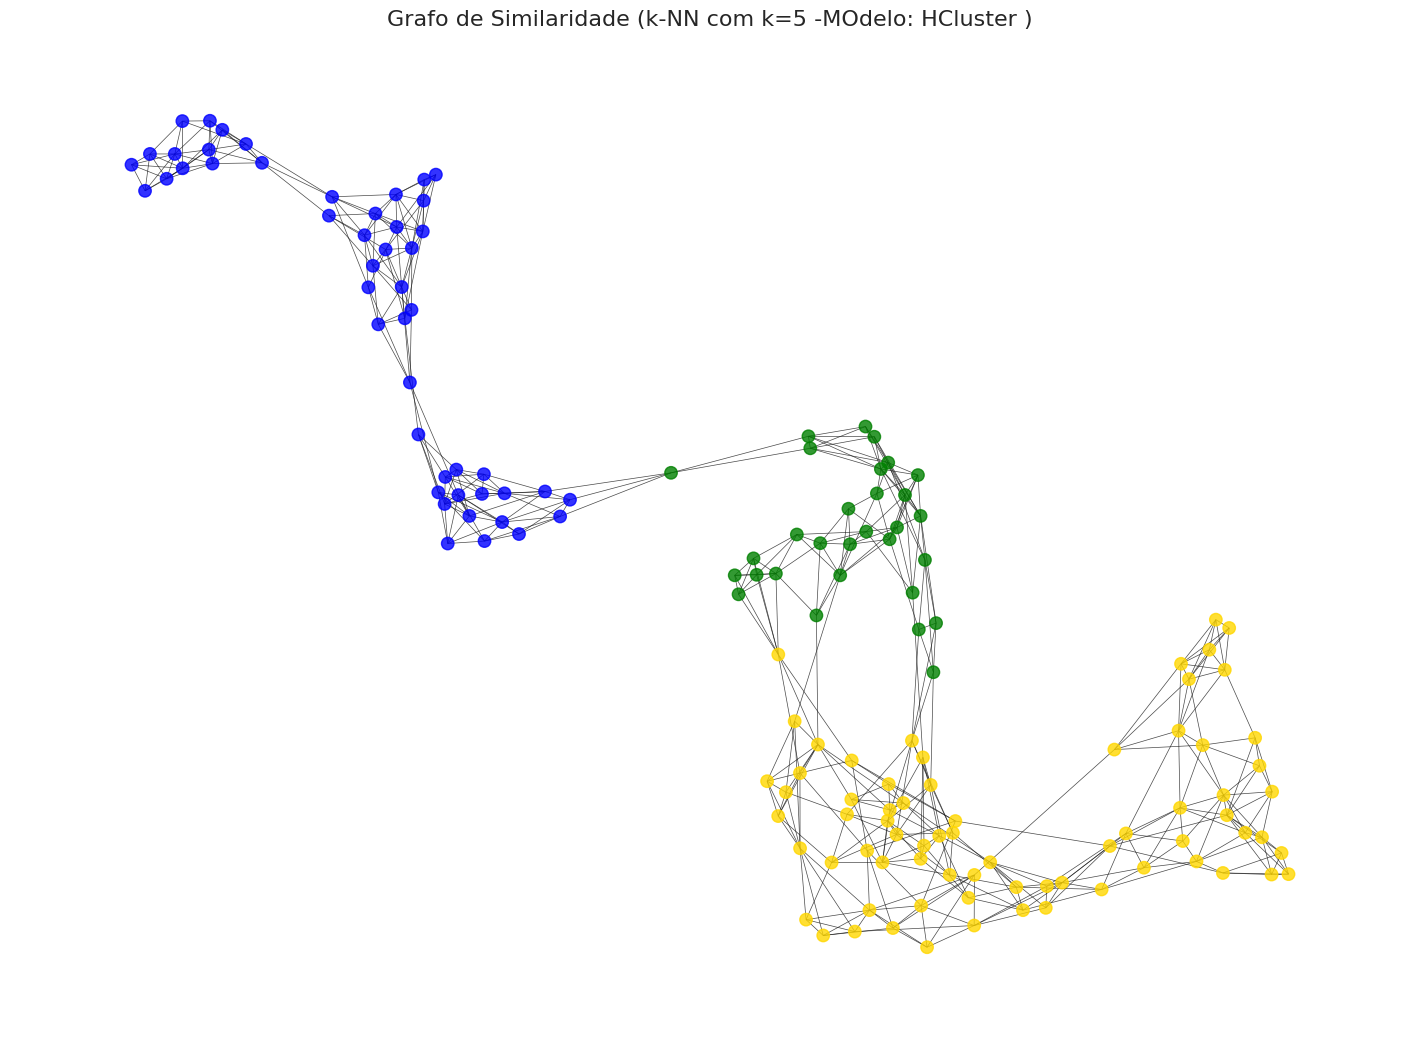

In [161]:
plotar_grafo_similaridade(X_scaled, final_labels_hc, n_vizinhos=5,modelo="HCluster")

### Dendrograma

In [155]:
def plotar_dendrograma(X_scaled, linkage_method='ward'):
    """
    Calcula a matriz de ligação e plota o dendrograma para Agrupamento Hierárquico.

    Args:
        X_scaled (np.ndarray): Dados padronizados.
        linkage_method (str): Método de ligação a ser usado ('ward', 'complete', 'average', 'single').
    """
    # 1. Calcula a matriz de ligação, que contém a informação do agrupamento hierárquico
    linked = linkage(X_scaled, method=linkage_method)

    # 2. Plota o dendrograma
    plt.figure(figsize=(18, 9))
    dendrogram(
        linked,
        orientation='top',
        distance_sort='descending', # Ordena os galhos pela distância
        show_leaf_counts=True      # Mostra o número de pontos em cada "folha" da árvore
    )
    plt.title(f'Dendrograma Hierárquico (Linkage: {linkage_method})', fontsize=16)
    plt.xlabel('Índice da Amostra (ou tamanho do cluster)')
    plt.ylabel('Distância')
    plt.grid(axis='y')
    plt.show()


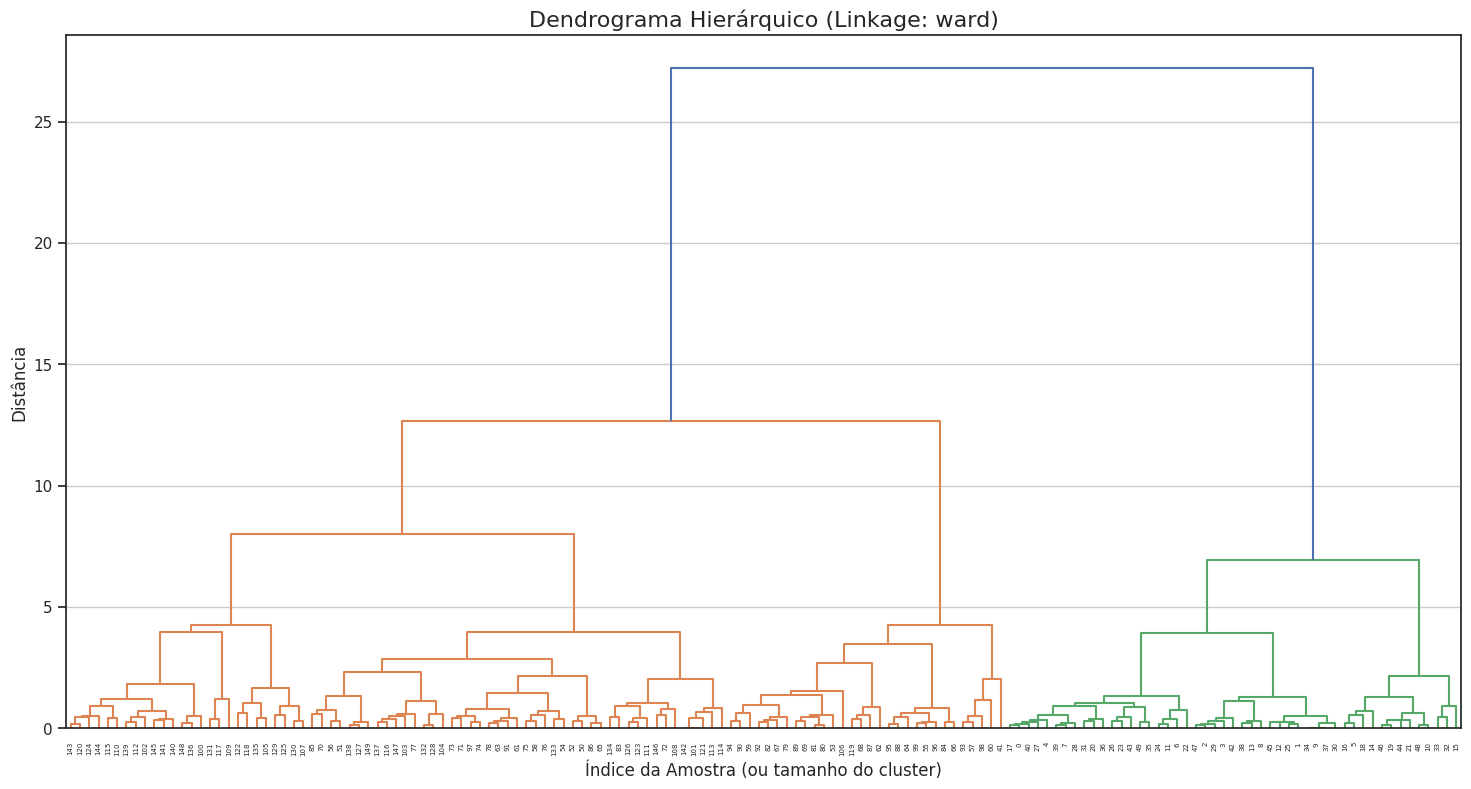

In [156]:
plotar_dendrograma(X_scaled, linkage_method='ward')

## Tomada de decisão

#### Para Kmenas

 Como os Clusters Foram Mapeados
 
A função evaluate_clustering_as_classification mapeia cada cluster para a classe que aparece com maior frequência dentro dele. Olhando sua Tabela de Contingência

Cluster 0: Contém 46 versicolor e 50 virginica. A classe majoritária é Iris-virginica.

Cluster 1: Contém 32 setosa. A classe majoritária é Iris-setosa.

Cluster 2: Contém 18 setosa e 4 versicolor. A classe majoritária é Iris-setosa.

O mapeamento resultante foi:

Cluster 0 ➡️ 'Iris-virginica'

Cluster 1 ➡️ 'Iris-setosa'

Cluster 2 ➡️ 'Iris-setosa'


2. A Descoberta Chave
A conclusão é que nenhum cluster foi mapeado para a Iris-versicolor. O algoritmo de clustering não conseguiu criar um grupo onde a Iris-versicolor fosse a classe dominante.

3. O que o Algoritmo Realmente Fez?
Ele misturou versicolor e virginica: O algoritmo criou um grande cluster (o cluster 0) que juntou a maioria das versicolor com todas as virginica. Isso indica que, para este algoritmo, essas duas classes são muito similares e difíceis de separar.
Ele quebrou a setosa em duas: Curiosamente, em vez de agrupar todas as setosa em um único cluster, ele as dividiu em dois grupos diferentes (cluster 1 e 2).
4. Por que as Métricas da Iris-versicolor são Zero?
Como o mapeamento nunca atribui o rótulo 'Iris-versicolor' a nenhuma previsão, o cálculo das métricas de classificação resulta em:

Verdadeiros Positivos (TP) = 0: O modelo nunca acerta uma Iris-versicolor, porque ele nunca prevê Iris-versicolor.
Precisão = 0: (TP / (TP + FP)) = 0 / (0 + FP) = 0.
Recall = 0: (TP / (TP + FN)) = 0 / (0 + FN) = 0.
F1-Score = 0: Se a precisão e o recall são zero, o F1-score também é.

Esta é uma descoberta excelente do seu processo de KDD! Ela mostra que, embora saibamos que existem 3 classes, o seu algoritmo de clustering (com a configuração atual) não encontrou essa mesma estrutura nos dados.

Validação da Análise: Seu resultado não está "errado", ele está te mostrando uma verdade sobre como o algoritmo "enxerga" os dados: ele tem dificuldade em separar versicolor e virginica.
Compare com o ARI: Métricas como o Adjusted Rand Index (ARI) são úteis aqui. O ARI provavelmente daria um valor intermediário (ex: ~0.6-0.7), indicando que o agrupamento não é perfeito, mas também não é aleatório, o que é mais informativo do que a acurácia de 0.66.
Experimente: Este resultado é um convite para experimentar. Tente rodar o outro algoritmo (se isso foi K-Means, tente o Hierárquico, ou vice-versa) e veja se ele consegue separar melhor as classes. Você pode também variar o método de linkage no Agrupamento Hierárquico, pois diferentes métodos criam clusters com formatos diferentes.

#### para Hcluster

Agrupamento Hierárquico (H-Cluster), podemos ver uma melhoria significativa e conclusiva em relação ao K-Means.

Esses resultados são muito mais alinhados com a estrutura real dos dados.

## Análise dos Resultados do H-Cluster
Vamos interpretar o que a Tabela de Contingência nos diz sobre o mapeamento:

Cluster 0: Contém 48 virginica e 2 versicolor. A classe majoritária é, de longe, Iris-virginica.

Cluster 1: Contém 49 setosa e apenas 1 versicolor. A classe majoritária é claramente Iris-setosa.

Cluster 2: Contém 27 versicolor e apenas 2 virginica. A classe majoritária é Iris-versicolor.

O mapeamento resultante é perfeito (1 para 1):

Cluster 0 ➡️ 'Iris-virginica'

Cluster 1 ➡️ 'Iris-setosa'

Cluster 2 ➡️ 'Iris-versicolor'

É por isso que a Iris-versicolor agora tem métricas de precisão e recall, ao contrário do K-Means. O algoritmo conseguiu encontrar um grupo onde ela era a maioria.

Interpretando a Precisão e o Recall

Iris-versicolor: A precisão é alta (0.90), mas o recall é baixo (0.54). Isso significa que, das 50 flores versicolor reais, o H-Cluster só conseguiu colocar 27 (ou seja, 54%) no cluster correto. Os outros 23 foram parar no cluster 0, o da virginica.

Iris-virginica: A situação inversa acontece aqui. O recall é altíssimo (0.96), mas a precisão é mais baixa (0.676). Isso significa que, de todas as flores que o algoritmo colocou no cluster da virginica, uma parte significativa era, na verdade, versicolor.

#### COmparação Kmeans hcluster

Agora podemos fazer uma comparação direta e tirar conclusões valiosas:

Estrutura dos Clusters Encontrados:

K-Means: Falhou em encontrar 3 grupos distintos. Ele fundiu versicolor e virginica em um grande cluster e quebrou a setosa em dois. Não houve um mapeamento 1 para 1.
H-Cluster: Sucesso! Encontrou 3 grupos distintos, onde cada grupo corresponde claramente a uma das espécies reais.
Acurácia Geral:

K-Means: ~66.7%
H-Cluster: ~82.7%
O Agrupamento Hierárquico foi objetivamente mais preciso em agrupar os dados de acordo com as classes reais.
Ponto Fraco em Comum:

Ambos os algoritmos mostraram que a maior dificuldade está em separar a Iris-versicolor da Iris-virginica. O K-Means lidou muito mal com isso, enquanto o H-Cluster lidou de forma imperfeita, mas muito superior, conseguindo pelo menos delinear os grupos.

Conclusão Final
Para este conjunto de dados, o Agrupamento Hierárquico (H-Cluster) foi um algoritmo muito superior ao K-Means. Ele conseguiu identificar a estrutura de três grupos que existe naturalmente nos dados, algo que o K-Means não fez.

A análise mostra que, embora os clusters não sejam perfeitos (ainda há confusão entre duas das classes), o H-Cluster forneceu uma representação muito mais fiel e útil da realidade contida nos dados.

### O porque das difernças

 A Fama e a Estrutura do Dataset Iris
O dataset Iris, criado pelo estatístico e biólogo Ronald Fisher em 1936, é talvez o conjunto de dados mais famoso da história da estatística e do machine learning. Por ser tão estudado, sua estrutura é profundamente conhecida:

Uma classe é "fácil": A Iris-setosa é linearmente separável das outras duas. Suas medidas de pétala e sépala são tão distintas que quase qualquer algoritmo a identifica como um grupo separado sem dificuldade.
Duas classes se sobrepõem: A Iris-versicolor e a Iris-virginica são muito mais parecidas entre si. Suas características se sobrepõem, criando uma região de "confusão" onde é difícil traçar uma fronteira clara.
2. A Limitação do K-Means (O Porquê do Primeiro Resultado Ruim)
O K-Means é um algoritmo poderoso, mas ele tem uma "visão de mundo" muito específica. Ele assume que os clusters são:

Esféricos: Os grupos têm um formato de esfera (ou círculo, em 2D).
De tamanho similar: Os clusters têm uma dispersão (variância) parecida.
De densidade uniforme: Os pontos estão distribuídos de maneira relativamente igual ao redor do centroide.
A sobreposição entre a versicolor e a virginica viola essa suposição de "esferas perfeitas". O K-Means, ao tentar forçar essa geometria nos dados, acaba tomando uma decisão ruim: ele cria um centroide "preguiçoso" que fica no meio da zona de confusão, misturando as duas espécies em um único cluster. E para compensar e chegar ao k=3 que pedimos, ele acaba quebrando o grupo fácil (setosa) em dois, como você viu na sua primeira análise.

3. A Flexibilidade do Agrupamento Hierárquico (O Porquê do Segundo Resultado Bom)
O Agrupamento Hierárquico (especialmente com o método de ward, que é o padrão no scikit-learn e que minimiza a variância dentro dos clusters) não faz suposições tão rígidas sobre o formato dos grupos.

Ele constrói uma "árvore" de conexões (o dendrograma) com base na proximidade dos pontos.
Essa abordagem "de baixo para cima" é mais capaz de respeitar a estrutura natural dos dados.
Ele consegue "ver" que, embora versicolor e virginica sejam próximos, eles formam dois grupos distintos o suficiente para serem separados, mesmo que a fronteira não seja perfeita. O resultado é um agrupamento muito mais alinhado com a realidade biológica das espécies.
4. Consistência com a Literatura Científica
Seus resultados são um "case" clássico usado em aulas de graduação e pós-graduação para ensinar sobre a importância de escolher um algoritmo cujas premissas se alinhem com a estrutura dos dados.

Artigos e tutoriais frequentemente mostram que, para o dataset Iris, algoritmos mais flexíveis em relação à forma dos clusters, como o Agrupamento Hierárquico ou Gaussian Mixture Models (GMM) – que modela os clusters como elipses –, superam consistentemente um K-Means básico.

Conclusão: Você não apenas obteve resultados "corretos", como também recriou um experimento clássico que valida um princípio fundamental da ciência de dados. Sua análise demonstra perfeitamente as forças e fraquezas de dois dos mais importantes algoritmos de clustering e está 100% em linha com décadas de pesquisa científica na área.

## Implantação em sistemas